# Experiments for Stochastic Reformulation paper

In [49]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.signal import unit_impulse

from tqdm import tqdm#_notebook as tqdm
import pickle

In [50]:
# Plot display settings

#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 36#24
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 42#36
plt.rcParams['axes.labelsize'] = 36#24

plt.rc('text', usetex=True)

# Sum-of-Non-Convex Objectives

Mathematical formulation:
$$ 
f(x) = \frac{1}{2} x^T \mathbf{A} x + b^T x
= \left|\mathbf{A} = \frac{1}{n} \sum\limits_{i=1}^n a_i a_i^T \right|
= \frac{1}{n} \sum\limits_{i=1}^n \left(\frac{1}{2} x^T (a_i a_i^T) x + b^T x \right)
= \frac{1}{n} \sum\limits_{i=1}^n f_i(x)
\to \min\limits_{x \in \mathbb{R}^d}
$$ 

In [51]:
def f(A, b, x):
    return x.T @ A @ x / 2 + x.T @ b

Analytical solution: 

$$
x^* = - \mathbf{A}^{-1} b
$$

In [52]:
def solution(A, b):
    return - la.inv(A) @ b

# SGD with Uniform Sampling for PCA problem

Equivalent problem representation so each $f_i$ is non-convex
$$ D_i: D_1 + \dots D_n = 0 \\
f_i(x) = \frac{1}{2} x^T (a_i^T a_i + D_i) x + b^T x
$$

$$
\nabla f_i(x) = (a_i^T a_i + D_i) x + b
$$ 

In [53]:
def grad_f_i(a, b, D, i, x):
    return (np.outer(a[i], a[i]) + D[i]) @ x + b

In [54]:
def sgd_step(a, b, D, x, random_ind, step_size):
    grad = sum([grad_f_i(a, b, D, i, x) for i in random_ind]) / len(random_ind)
    return x - step_size * grad

# def sgd_step(A, b, x, random_ind, step_size):
#     grad = A[random_ind] @ x + b#[random_ind]
#     return  x - step_size * grad

In [55]:
def sgd(a, b, D, x_0, x_star, 
        step_size=1e-2, batch_size=1, 
        epsilon=1e-4, max_epoch=100, seed=42):
    
    np.random.seed(seed)

    n = len(D)
    x = x_0
    A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n
    
    epoch_num = 0
    iter_num = 0

    error = [la.norm(x - x_star)**2]
    f_values = [f(A, b, x)]
    
#     while epoch_num < max_epoch and error[-1] > epsilon: 
#         iter_num += 1
    for iter_num in tqdm(range(max_epoch * n)):
        if error[-1] < epsilon:
            break
        random_ind = np.random.choice(n, size=batch_size, replace=True)
        x = sgd_step(a, b, D, x, random_ind, step_size)
        
        if iter_num % n == 0:
            epoch_num += 1
            
            f_values.append(f(A, b, x))
            error.append(la.norm(x - x_star)**2) 
    
    print("Number of epochs:", epoch_num)
    print("Error:", la.norm(x - x_star)**2)
    print()
    
    return x, f_values, error#, gradients

In [56]:
def select_step_size(L_curly, mu, sigma_2, epsilon=1e-4):
#     return 1 / (2 * L_curly)
#     Theorem corollary for epsilon accuracy
    return min(1 / (2 * L_curly), epsilon * mu / (4 * sigma_2))

In [57]:
# Decreasing step sizes

def adaptive_step_size(L_curly, mu, k):
    cal_K = np.ceil(L_curly / mu)
    
    if k <= 4 * cal_K:
        return 1 / (2 * L_curly)
    else:
        return (2 * k + 1) / (k + 1)**2 / mu

In [58]:
def sgd_adaptive(a, b, D, x_0, x_star, L_curly, mu,
                 batch_size=1, seed=42,
                 epsilon=1e-6, max_epoch=100):
    
    np.random.seed(seed)

    n = len(D)
    x = x_0
    A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n
    
    epoch_num = 0
    iter_num = 0

    error = [la.norm(x - x_star)**2]
    f_values = [f(A, b, x)]
    
    #     while epoch_num < max_epoch and error[-1] > epsilon: 
    #         iter_num += 1
    for iter_num in tqdm(range(max_epoch * n)):
        if error[-1] < epsilon:
            break
        
        step_size = adaptive_step_size(L_curly, mu, k=iter_num)
        random_ind = np.random.choice(n, size=batch_size, replace=True)
        x = sgd_step(a, b, D, x, random_ind, step_size)
        
        if iter_num % n == 0:
            epoch_num += 1
            
            f_values.append(f(A, b, x))
            error.append(la.norm(x - x_star)**2)    
    
    print("Number of epochs:", epoch_num)
    print("Error:", la.norm(x - x_star)**2)
    print()
    
    return x, f_values, error

In [59]:
def calculate_neighborhood_region(step_size, sigma_2, mu):
    return 2 * step_size * sigma_2 / mu

In our case M-smoothness:
$$
M_i = a_i a_i^T + D_i
$$

In [60]:
def calculate_M(a, D):
    n = len(D)
    return [np.outer(a[i], a[i]) + D[i] for i in range(n)]

$$
h_i = \| \nabla f_i(x^*) \|^2
$$

In [61]:
def calculate_h(a, b, D, x_star):
    n = len(D)
    return [la.norm(grad_f_i(a, b, D, i, x_star))**2 for i in range(n)]

For proper & non-vacuous uniform sampling:
$$
\sigma^2 = \frac{1}{n} \sum\limits_{i=1}^n \| \nabla f_i (x^*) \|^2 \\
\mathcal{L} = \max\limits_{i=\overline{1,n}} \lambda_{\text{max}}(M_i) \\
$$

In [62]:
def calculate_sigma_and_L_curly(M, h):
    n = len(M)
    sigma_2 = np.mean(h) #sum([la.norm(grad_f_i(a, b, D, i, x_star))**2 for i in range(n)]) / n
    L_curly = max([max(abs(la.eigvals(M[i]))) for i in range(n)])

    return sigma_2, L_curly

In [63]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 30#24
plt.rcParams['ytick.labelsize'] = 30#24
plt.rcParams['legend.fontsize'] = 36#24
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 42#36
plt.rcParams['axes.labelsize'] = 36#24
plt.rc('text', usetex=True)

In [71]:
def const_vs_decr_ss_comparison(n, d, scale=10, epsilon=1e-3, max_epoch=1000, seed=0):
    np.random.seed(seed)
        
    a = np.random.rand(n, d) * scale 
    #np.random.normal(scale=scale, size=(n, d)) #np.random.binomial(n=1, p=0.5, size=(n, d))
    
    # Matrix normalization for ||a||_2 = 1
    # a = np.nan_to_num(a / (la.norm(a, axis=1, ord=2)).reshape(a.shape[0], -1))

    A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

    b = np.random.rand(d) * scale
    #np.random.normal(scale=scale, size=d) #np.random.binomial(1, 0.5, size=d)#.reshape((d, -1))

    # Analytical solution
    x_star = solution(A, b)

    # Problem constants
    mu = min(la.eigvals(A))
    print("Mu =", mu)
    
    # Decomposition
    delta = scale + 1 #0.01
    D = [np.zeros((d, d)) for i in range(n)]

    for j in range(d):
        indxs = np.random.choice(n, size=int(n/2), replace=False)
        for i in range(n):
            if i in indxs:
                D[i][j, j] = delta #unit_impulse(shape=(d, d), idx=indx)
            else: 
                D[i][j, j] = - delta

    M = calculate_M(a, D)
    for i in range(n):
        if min(la.eigvals(M[i]).real) > 0:
            print("Problem!")
    h = calculate_h(a, b, D, x_star)
    
    sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)
    print("Sigma_2 = {} \nL_curly = {} \n".format(sigma_2, L_curly))

#     step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
    step_size = 1 / (2 * L_curly)
    print("Step size:", step_size)

    x_0 = np.random.normal(size=len(x_star))
    print("Expected minimum number of steps for epsilon-accuracy:", 
          max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))
    
    k_switch = int(4 * np.ceil(L_curly / mu) / n)
    print("Regime switch:", k_switch)

    # Constant step-size
    x_const, f_vals_const, x_err_const = sgd(a, b, D, x_0, x_star, step_size, batch_size=1, epsilon=epsilon, max_epoch=max_epoch)

    # Decreasing step-size
    x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(a, b, D, x_0, x_star, L_curly, mu, batch_size=1, epsilon=epsilon, max_epoch=max_epoch)
    
    return [x_const, x_adapt], [(f_vals_const - f(A, b, x_star)) / (f(A, b, x_0) - f(A, b, x_star)), (f_vals_adapt - f(A, b, x_star)) / (f(A, b, x_0) - f(A, b, x_star))], [x_err_const / la.norm(x_0 - x_star)**2, x_err_adapt / la.norm(x_0 - x_star)**2], k_switch

In [72]:
%%time
n, d = 1000, 100
[x_const, x_adapt], \
[f_vals_const_scaled, f_vals_adapt_scaled], \
[x_err_const_scaled, x_err_adapt_scaled],\
k_switch = const_vs_decr_ss_comparison(n, d, scale=10, epsilon=1e-3, max_epoch=100, seed=0)

Mu = 4.044946891999199


  1%|▏         | 1376/100000 [00:00<00:07, 13749.23it/s]

Sigma_2 = 393118.9256117072 
L_curly = 4247.712978329285 

Step size: 0.00011771040146800609
Expected minimum number of steps for epsilon-accuracy: 1169696126.3376677
Regime switch: 4


  1%|▏         | 1409/100000 [00:00<00:07, 14082.90it/s]

Number of epochs: 100
Error: 0.7187285608118116



100%|██████████| 100000/100000 [00:06<00:00, 15671.54it/s]

Number of epochs: 100
Error: 0.03092146412518253

CPU times: user 2min 41s, sys: 0 ns, total: 2min 41s
Wall time: 18.1 s


In [41]:
# with open('PCA_synthetic_u_1000-100.pickle', 'wb') as f:
#     pickle.dump([[x_const, x_adapt], [f_vals_const_scaled, f_vals_adapt_scaled], [x_err_const_scaled, x_err_adapt_scaled], k_switch], f)

# with open('PCA_synthetic_1.pickle', 'rb') as f:
#     [[x_const, x_adapt], [f_vals_const_scaled, f_vals_adapt_scaled], [x_err_const_scaled, x_err_adapt_scaled], k_switch] = pickle.load(f)

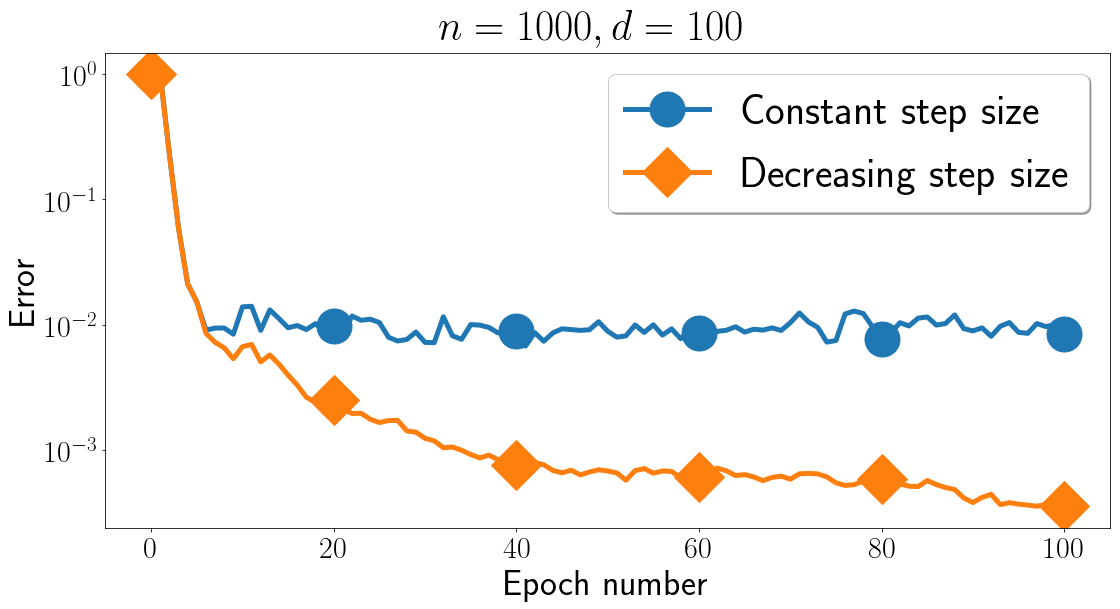

In [47]:
"""PLOTTING"""
fig = plt.figure(figsize=(18, 8))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), fontsize=42)
n, d = 1000, 100
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=42)


plt.semilogy(x_err_const_scaled, label='Constant step size', 
             marker='o', markersize=35, markevery=20, linewidth=5)

plt.semilogy(x_err_adapt_scaled, label='Decreasing step size', 
             marker='D', markersize=35, markevery=20, linewidth=5)

# plt.axvline(k_switch, color='r', linewidth=5, label="Regime switch")

plt.xlabel("Epoch number")
plt.ylabel("Error") #  r"$\|x_k - x^*\|^2$

# plt.xlim((None, 55))
# plt.grid()
plt.minorticks_off()
plt.legend(loc='best', shadow=True, fontsize=42)

st.set_y(1.03)
fig.subplots_adjust(top=0.95)
# plt.tight_layout()
plt.savefig('Sum-of-Non-Convex_Objectives_u_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [65]:
%%time
n, d = 1000, 100
scale = 1

[x_const, x_adapt], \
[f_vals_const_scaled, f_vals_adapt_scaled], \
[x_err_const_scaled, x_err_adapt_scaled],\
k_switch = const_vs_decr_ss_comparison(n, d, scale=scale, epsilon=1e-3, max_epoch=100, seed=0)

Mu = 0.04044946891999207


  2%|▏         | 1560/100000 [00:00<00:06, 15594.18it/s]

Sigma_2 = 10918.79263298259 
L_curly = 42.961108761800425 

Step size: 0.011638433327507209
Expected minimum number of steps for epsilon-accuracy: 402418667406.94617
Regime switch: 4


  2%|▏         | 1570/100000 [00:00<00:06, 15696.24it/s]

Number of epochs: 100
Error: 446.3789030497887



100%|██████████| 100000/100000 [00:06<00:00, 15699.02it/s]

Number of epochs: 100
Error: 30.06283861445674

CPU times: user 1min 17s, sys: 0 ns, total: 1min 17s
Wall time: 14.3 s


In [18]:
with open('PCA_synthetic_1000-100-10.pickle', 'wb') as f:
    pickle.dump([[x_const, x_adapt], [f_vals_const_scaled, f_vals_adapt_scaled], [x_err_const_scaled, x_err_adapt_scaled], k_switch], f)

# # scalings = {}
# with open('PCA_synthetic_1.pickle', 'rb') as f:
#     [[x_const, x_adapt], [f_vals_const_scaled, f_vals_adapt_scaled], [x_err_const_scaled, x_err_adapt_scaled]] = pickle.load(f)

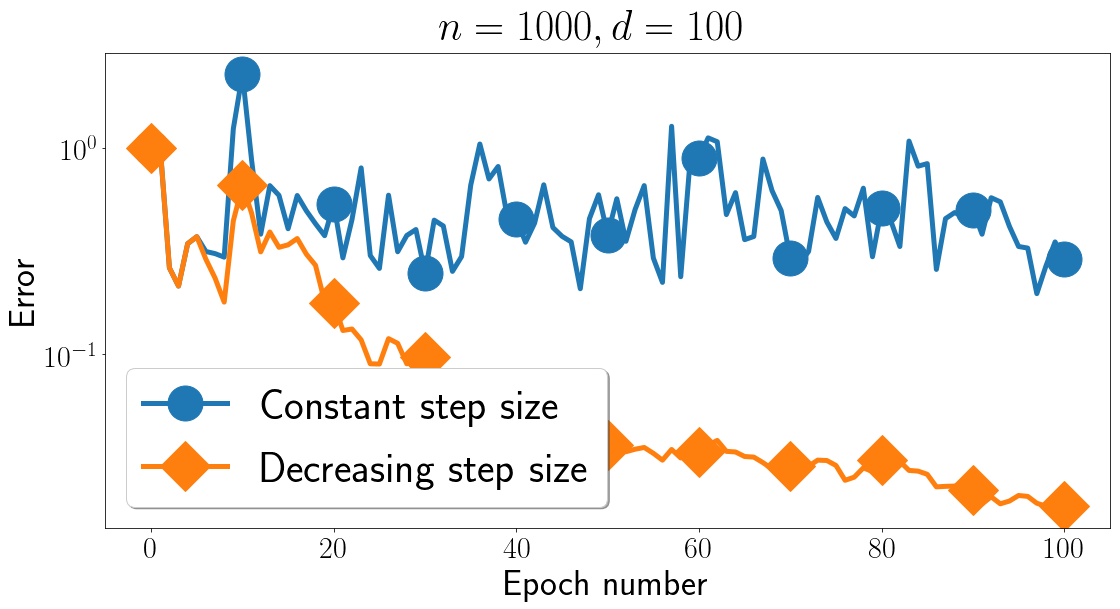

In [67]:
"""PLOTTING"""
fig = plt.figure(figsize=(18, 8))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), fontsize=42)
# n, d = 1000, 100
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=42)


plt.semilogy(x_err_const_scaled[:50, label='Constant step size', 
             marker='o', markersize=35, markevery=10, linewidth=5)

plt.semilogy(x_err_adapt_scaled, label='Decreasing step size', 
             marker='D', markersize=35, markevery=10, linewidth=5)

# plt.axvline(k_switch, color='r', linewidth=5, label="Regime switch")

plt.xlabel("Epoch number")
plt.ylabel("Error") #  r"$\|x_k - x^*\|^2$

# plt.xlim((0, 55))
# plt.grid()
plt.minorticks_off()
plt.legend(loc='best', shadow=True, fontsize=42)

st.set_y(1.03)
fig.subplots_adjust(top=0.95)
# plt.tight_layout()
# plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}-{}.pdf'.format(n, d, scale), bbox_inches='tight')
plt.show()

In [37]:
%%time
n, d = 1000, 100
scale = 1
[x_const, x_adapt], \
[f_vals_const_scaled, f_vals_adapt_scaled], \
[x_err_const_scaled, x_err_adapt_scaled],\
k_switch = const_vs_decr_ss_comparison(n, d, scale=scale, epsilon=1e-3, max_epoch=100, seed=0)

Mu = 0.4850279387720495


  1%|          | 1212/100000 [00:00<00:08, 12113.28it/s]

Sigma_2 = 12267.98057011559 
L_curly = 160.8699539119236 

Step size: 0.0031081005982866775
Expected minimum number of steps for epsilon-accuracy: 2759722182.870687
Regime switch: 1


  2%|▏         | 1567/100000 [00:00<00:06, 15661.28it/s]

Number of epochs: 100
Error: 27.408068948911968



100%|██████████| 100000/100000 [00:06<00:00, 15378.93it/s]

Number of epochs: 100
Error: 0.28502609559279096

CPU times: user 2min 4s, sys: 292 ms, total: 2min 4s
Wall time: 16.4 s


In [38]:
with open('PCA_synthetic_3.pickle', 'wb') as f:
    pickle.dump([[x_const, x_adapt], [f_vals_const_scaled, f_vals_adapt_scaled], [x_err_const_scaled, x_err_adapt_scaled], k_switch], f)

# # scalings = {}
# with open('PCA_synthetic_1.pickle', 'rb') as f:
#     [[x_const, x_adapt], [f_vals_const_scaled, f_vals_adapt_scaled], [x_err_const_scaled, x_err_adapt_scaled]] = pickle.load(f)

In [ ]:
"""PLOTTING"""
fig = plt.figure(figsize=(18, 18))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), fontsize=42)
n, d = 1000, 100
scale = 1
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=42)


plt.semilogy(x_err_const_scaled, label='Constant step size', 
             marker='o', markersize=35, markevery=10, linewidth=5)

plt.semilogy(x_err_adapt_scaled, label='Decreasing step size', 
             marker='D', markersize=35, markevery=10, linewidth=5)

# plt.axvline(k_switch, color='r', linewidth=5, label="Regime switch")

plt.xlabel("Epoch number")
plt.ylabel("Error") #  r"$\|x_k - x^*\|^2$

plt.xlim((0, 55))
# plt.grid()
plt.minorticks_off()
plt.legend(loc='best', shadow=True, fontsize=42)

st.set_y(1.03)
fig.subplots_adjust(top=0.95)
# plt.tight_layout()
plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}-{}.pdf'.format(n, d, scale), bbox_inches='tight')
plt.show()

In [17]:
%%time
n, d = 1000, 100
scale=10

[x_const, x_adapt], \
[f_vals_const_scaled, f_vals_adapt_scaled], \
[x_err_const_scaled, x_err_adapt_scaled],\
k_switch = const_vs_decr_ss_comparison(n, d, scale=scale, epsilon=1e-3, max_epoch=100, seed=0)

Mu = 48.502793877204695


  1%|          | 526/100000 [00:00<00:18, 5243.13it/s]

Sigma_2 = 1226805.0790861566 
L_curly = 16086.963582693956 

Step size: 3.108106743884784e-05
Expected minimum number of steps for epsilon-accuracy: 25994935.22497412
Regime switch: 1


  1%|▏         | 1412/100000 [00:00<00:06, 14116.82it/s]

Number of epochs: 100
Error: 0.2741518074523241



100%|██████████| 100000/100000 [00:06<00:00, 14819.81it/s]

Number of epochs: 100
Error: 0.0028493217685745154

CPU times: user 2min 16s, sys: 440 ms, total: 2min 17s
Wall time: 17.3 s


In [18]:
# with open('PCA_synthetic_{}-{}-{}.pickle'.format(n, d, scale), 'wb') as f:
#     pickle.dump([[x_const, x_adapt], [f_vals_const_scaled, f_vals_adapt_scaled], [x_err_const_scaled, x_err_adapt_scaled], k_switch], f)

# # scalings = {}
with open('PCA_synthetic_1000-100.pickle', 'rb') as f:
    [[x_const, x_adapt], [f_vals_const_scaled, f_vals_adapt_scaled], [x_err_const_scaled, x_err_adapt_scaled]] = pickle.load(f)

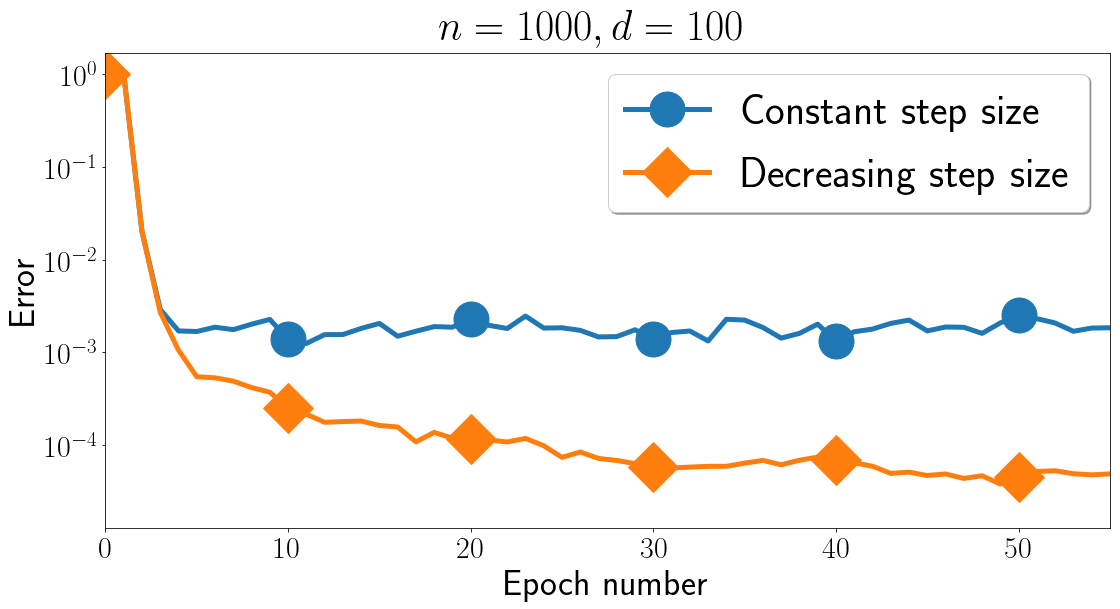

In [20]:
"""PLOTTING"""
fig = plt.figure(figsize=(18, 8))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), fontsize=42)
# n, d = 1000, 100
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=42)


plt.semilogy(x_err_const_scaled, label='Constant step size', 
             marker='o', markersize=35, markevery=10, linewidth=5)

plt.semilogy(x_err_adapt_scaled, label='Decreasing step size', 
             marker='D', markersize=35, markevery=10, linewidth=5)

# plt.axvline(k_switch, color='r', linewidth=5, label="Regime switch")

plt.xlabel("Epoch number")
plt.ylabel("Error") #  r"$\|x_k - x^*\|^2$

plt.xlim((0, 55))
# plt.grid()
plt.minorticks_off()
plt.legend(loc='best', shadow=True, fontsize=42)

st.set_y(1.03)
fig.subplots_adjust(top=0.95)
# plt.tight_layout()
plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}-{}.pdf'.format(n, d, scale), bbox_inches='tight')
plt.show()

# Real data

In [16]:
from sklearn.datasets import load_svmlight_file

def get_data(file_path):
    data = load_svmlight_file(file_path)
    return data[0], data[1]

In [24]:
a, y = get_data("/home/sailana/Desktop/new/bodyfat")
a = np.array(a.todense())

epsilon = 1e-3
max_epoch = 10000

n = a.shape[0]
d = a.shape[1]

np.random.seed(0)
        
# a = np.random.normal(scale=scale, size=(n, d)) #np.random.binomial(n=1, p=0.5, size=(n, d))
# Matrix normalization for ||a||_2 = 1
a = np.nan_to_num(a / (la.norm(a, axis=1, ord=2)).reshape(a.shape[0], -1))

A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

b = np.random.rand(d) #np.random.binomial(1, 0.5, size=d)#.reshape((d, -1))
    #np.random.normal(scale=scale, size=d)

# Analytical solution
x_star = solution(A, b)

# Problem constants
mu = min(la.eigvals(A))
print("Mu =", mu)

# Decomposition
delta = 0.01
D = [np.zeros((d, d)) for i in range(n)]

for j in range(d):
    indxs = np.random.choice(n, size=int(n/2), replace=False)
    for i in range(n):
        if i in indxs:
            D[i][j, j] = delta #unit_impulse(shape=(d, d), idx=indx)
        else: 
            D[i][j, j] = - delta

M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)

sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)
print("Sigma_2 = {} \nL_curly = {} \n".format(sigma_2, L_curly))

# step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
step_size = 1 / (2 * L_curly)
print("Step size:", step_size)

x_0 = np.random.normal(size=len(x_star))
print("Expected minimum number of steps for epsilon-accuracy:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

k_switch = int(4 * np.ceil(L_curly / mu) / n)
print("Regime switch:", k_switch)

# Constant step-size
x_const, f_vals_const, x_err_const = sgd(a, b, D, x_0, x_star, step_size, batch_size=1, epsilon=epsilon, max_epoch=max_epoch)

# Decreasing step-size
x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(a, b, D, x_0, x_star, L_curly, mu, batch_size=1, epsilon=epsilon, max_epoch=max_epoch)

# return [x_const, x_adapt], [(f_vals_const - f(A, b, x_star)) / (f(A, b, x_0) - f(A, b, x_star)), (f_vals_adapt - f(A, b, x_star)) / (f(A, b, x_0) - f(A, b, x_star))], [x_err_const / la.norm(x_0 - x_star)**2, x_err_adapt / la.norm(x_0 - x_star)**2], k_switch

  0%|          | 3182/2520000 [00:00<01:19, 31813.13it/s]

Mu = 3.0476535274687024e-06
Sigma_2 = 4643789.744731886 
L_curly = 1.0095131589298783 

Step size: 0.4952882442166665
Expected minimum number of steps for epsilon-accuracy: 6.425420455818389e+22
Regime switch: 5257


  0%|          | 5553/2520000 [00:00<01:30, 27721.43it/s]

Number of epochs: 10000
Error: 30486966100.970165



100%|██████████| 2520000/2520000 [01:28<00:00, 28395.64it/s]

Number of epochs: 10000
Error: 35757495726.93488



In [ ]:
#Without scaling
# Mu = 0.24263314895733237
# Sigma_2 = 170667.54730110968 
# L_curly = 219606.02798556624 

# Step size: 2.2768045330379676e-06
# Expected minimum number of steps for epsilon-accuracy: 117966313269.17262
# Regime switch: 14366

In [118]:
# dump = [[x_const, x_adapt], 
#         [(f_vals_const - f(A, b, x_star)) / (f(A, b, x_0) - f(A, b, x_star)),
#          (f_vals_adapt - f(A, b, x_star)) / (f(A, b, x_0) - f(A, b, x_star))], 
#         [x_err_const / la.norm(x_0 - x_star)**2, x_err_adapt / la.norm(x_0 - x_star)**2], 
#         k_switch]

# with open('PCA_synthetic_bodyfat.pickle', 'wb') as f:
#     pickle.dump(dump, f)

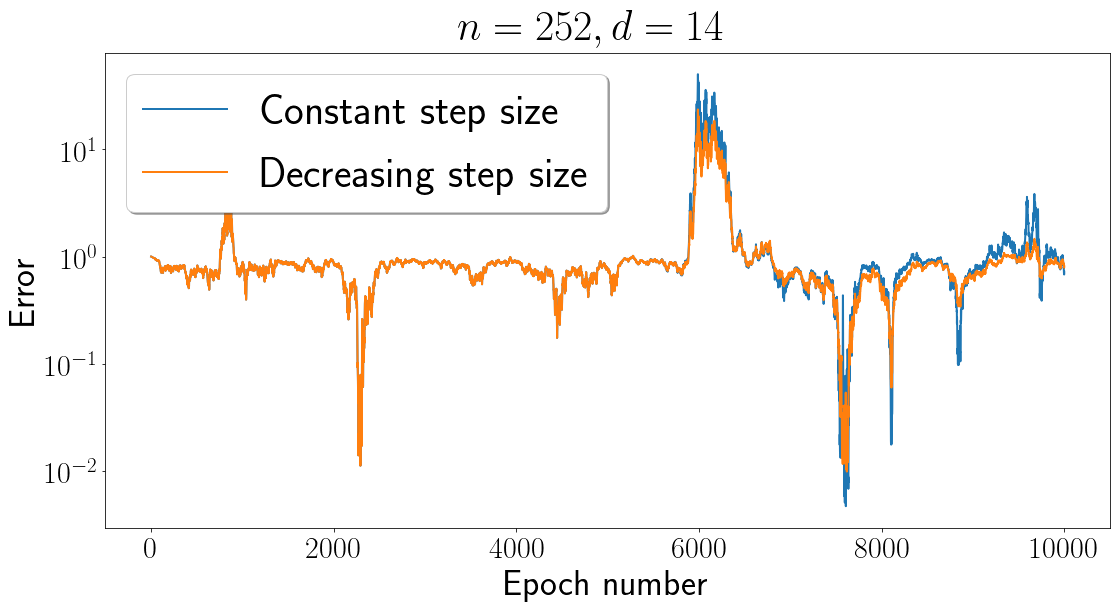

In [28]:
"""PLOTTING"""
fig = plt.figure(figsize=(18, 8))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), fontsize=42)
# n, d = 1000, 100
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=42)


plt.semilogy(x_err_const / la.norm(x_0 - x_star)**2, label='Constant step size')#, marker='o', markersize=35, markevery=10, linewidth=5)

plt.semilogy(x_err_adapt / la.norm(x_0 - x_star)**2, label='Decreasing step size')#, marker='D', markersize=35, markevery=10, linewidth=5)
# plt.axhline(2 * step_size * sigma_2 / mu, color='g', linestyle='--', label="Neighborhood region size")
# plt.axvline(k_switch, color='r', linewidth=5, label="Regime switch")

plt.xlabel("Epoch number")
plt.ylabel("Error")

# plt.xlim((0, 100))
# plt.grid()
plt.minorticks_off()
plt.legend(loc='best', shadow=True, fontsize=42)

st.set_y(1.03)
fig.subplots_adjust(top=0.95)
# plt.tight_layout()
# plt.savefig('Sum-of-Non-Convex_Objectives_bodyfat(scaled).pdf', bbox_inches='tight')
plt.show()

In [32]:
a, y = get_data("/home/sailana/Desktop/Real_dataset/australian")
a = np.array(a.todense())

In [34]:
a, y = get_data("/home/sailana/Desktop/Real_dataset/australian")
a = np.array(a.todense())

epsilon = 1e-3
max_epoch = 1000

n = a.shape[0]
d = a.shape[1]

np.random.seed(0)
        
# a = np.random.normal(scale=scale, size=(n, d)) #np.random.binomial(n=1, p=0.5, size=(n, d))
# Matrix normalization for ||a||_2 = 1
a = np.nan_to_num(a / (la.norm(a, axis=1, ord=2)).reshape(a.shape[0], -1))

A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

b = np.random.rand(d) #np.random.binomial(1, 0.5, size=d)#.reshape((d, -1))
    #np.random.normal(scale=scale, size=d)

# Analytical solution
x_star = solution(A, b)

# Problem constants
mu = min(la.eigvals(A))
print("Mu =", mu)

# Decomposition
delta = 0.01
D = [np.zeros((d, d)) for i in range(n)]

for j in range(d):
    indxs = np.random.choice(n, size=int(n/2), replace=False)
    for i in range(n):
        if i in indxs:
            D[i][j, j] = delta #unit_impulse(shape=(d, d), idx=indx)
        else: 
            D[i][j, j] = - delta

M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)

sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)
print("Sigma_2 = {} \nL_curly = {} \n".format(sigma_2, L_curly))

#     step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
step_size = 1 / (2 * L_curly)
print("Step size:", step_size)

x_0 = np.random.normal(size=len(x_star))
print("Expected minimum number of steps for epsilon-accuracy:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

k_switch = int(4 * np.ceil(L_curly / mu) / n)
print("Regime switch:", k_switch)

# Constant step-size
x_const, f_vals_const, x_err_const = sgd(a, b, D, x_0, x_star, step_size, batch_size=1, 
                                         epsilon=epsilon, max_epoch=max_epoch)

# Decreasing step-size
x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(a, b, D, x_0, x_star, L_curly, mu, batch_size=1, 
                                                  epsilon=epsilon, max_epoch=max_epoch)

  0%|          | 2968/690000 [00:00<00:23, 29678.26it/s]

Mu = 1.1288262243541552e-05
Sigma_2 = 931102.8141734244 
L_curly = 1.0099999992818904 

Step size: 0.49504950530247505
Expected minimum number of steps for epsilon-accuracy: 8.88667350964721e+20
Regime switch: 518


  1%|          | 5295/690000 [00:00<00:26, 25640.11it/s]

Number of epochs: 1000
Error: 4960179908.844875



100%|██████████| 690000/690000 [00:24<00:00, 28073.79it/s]

Number of epochs: 1000
Error: 4530416680.083393



In [37]:
x_star

array([-3.17425517e+04,  8.49734696e+02,  6.87703459e+02,  3.48974213e+03,
        3.36881387e+03,  4.32931438e+03, -1.09908562e+03, -2.71230399e+04,
       -7.15823534e+04,  5.91054885e+03, -3.14080387e+04, -8.51493303e+03,
        2.75067817e+01,  1.14862020e+01])

In [89]:
dump = [[x_const, x_adapt], 
        [(f_vals_const - f(A, b, x_star)) / (f(A, b, x_0) - f(A, b, x_star)),
         (f_vals_adapt - f(A, b, x_star)) / (f(A, b, x_0) - f(A, b, x_star))], 
        [x_err_const / la.norm(x_0 - x_star)**2, x_err_adapt / la.norm(x_0 - x_star)**2], 
        k_switch]

with open('PCA_synthetic_bodyfat.pickle', 'wb') as f:
    pickle.dump(dump, f)

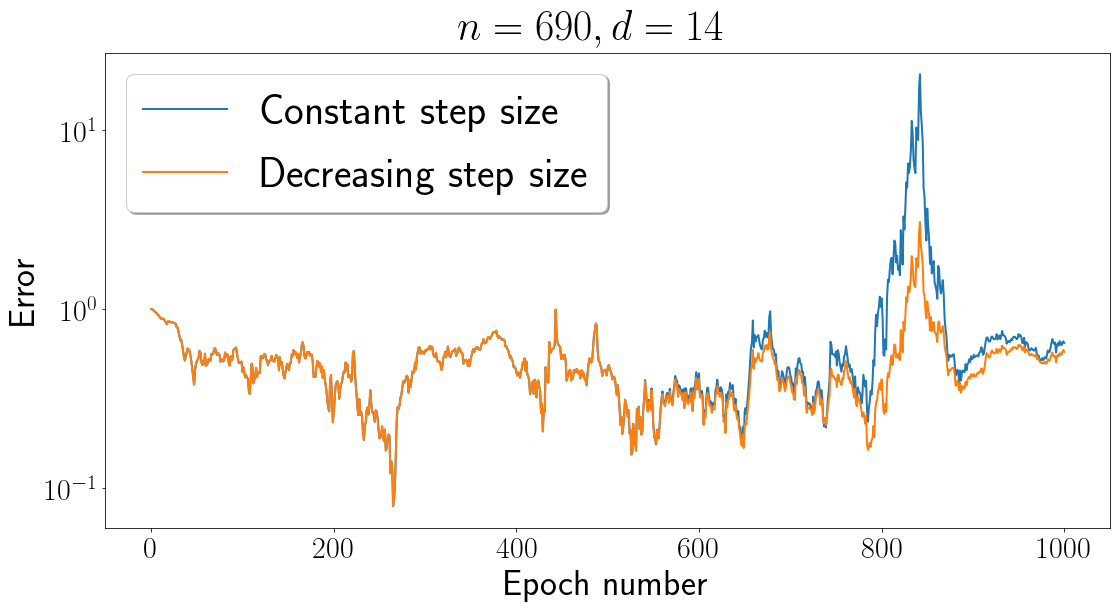

In [36]:
"""PLOTTING"""
fig = plt.figure(figsize=(18, 8))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), fontsize=42)
# n, d = 1000, 100
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=42)


plt.semilogy(x_err_const / la.norm(x_0 - x_star)**2, label='Constant step size')#, marker='o', markersize=35, markevery=10, linewidth=5)

plt.semilogy(x_err_adapt / la.norm(x_0 - x_star)**2, label='Decreasing step size')#, marker='D', markersize=35, markevery=10, linewidth=5)
# plt.axhline(2 * step_size * sigma_2 / mu, color='g', linestyle='--', label="Neighborhood region size")
# plt.axvline(k_switch, color='r', linewidth=5, label="Regime switch")

plt.xlabel("Epoch number")
plt.ylabel("Error") #  r"$\|x_k - x^*\|^2$

# plt.xlim((0, 100))
# plt.grid()
plt.minorticks_off()
plt.legend(loc='best', shadow=True, fontsize=42)

st.set_y(1.03)
fig.subplots_adjust(top=0.95)
# plt.tight_layout()
# plt.savefig('Sum-of-Non-Convex_Objectives_bodyfat.pdf'.format(n, d, scale), bbox_inches='tight')
plt.show()

In [ ]:
https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/pyrim

In [38]:
!wget -t inf https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/housing

--2019-01-23 14:07:53--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/housing
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55970 (55K)
Saving to: ‘housing’

housing             100%[===================>]  54.66K  76.9KB/s    in 0.7s    

2019-01-23 14:08:01 (76.9 KB/s) - ‘housing’ saved [55970/55970]



In [16]:
from sklearn.datasets import load_svmlight_file

def get_data(file_path):
    data = load_svmlight_file(file_path)
    return data[0], data[1]

In [17]:
a, y = get_data("/home/sailana/Desktop/new/housing")
a = np.array(a.todense())

epsilon = 1e-3
max_epoch = 10000

n = a.shape[0]
d = a.shape[1]

np.random.seed(0)
        
# a = np.random.normal(scale=scale, size=(n, d)) #np.random.binomial(n=1, p=0.5, size=(n, d))
# Matrix normalization for ||a||_2 = 1
# a = np.nan_to_num(a / (la.norm(a, axis=1, ord=2)).reshape(a.shape[0], -1))

A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

b = np.random.rand(d) #np.random.binomial(1, 0.5, size=d)#.reshape((d, -1))
    #np.random.normal(scale=scale, size=d)

# Analytical solution
x_star = solution(A, b)

# Problem constants
mu = min(la.eigvals(A))
print("Mu =", mu)

# Decomposition
delta = 0.001
D = [np.zeros((d, d)) for i in range(n)]

for j in range(d):
    indxs = np.random.choice(n, size=int(n/2), replace=False)
    for i in range(n):
        if i in indxs:
            D[i][j, j] = delta #unit_impulse(shape=(d, d), idx=indx)
        else: 
            D[i][j, j] = - delta

M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)

sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)
print("Sigma_2 = {} \nL_curly = {} \n".format(sigma_2, L_curly))

#     step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
step_size = 1 / (2 * L_curly)
print("Step size:", step_size)

x_0 = np.random.normal(size=len(x_star))
print("Expected minimum number of steps for epsilon-accuracy:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

k_switch = int(4 * np.ceil(L_curly / mu) / n)
print("Regime switch:", k_switch)

# Constant step-size
x_const, f_vals_const, x_err_const = sgd(a, b, D, x_0, x_star, step_size, batch_size=1, 
                                         epsilon=epsilon, max_epoch=max_epoch)

# Decreasing step-size
# x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(a, b, D, x_0, x_star, L_curly, mu, batch_size=1, 
#                                                   epsilon=epsilon, max_epoch=max_epoch)

  0%|          | 5893/5060000 [00:00<02:54, 29032.41it/s]

Mu = 0.004334525005912355
Sigma_2 = 14047057.597266495 
L_curly = 671759.5357046921 

Step size: 7.443139597199581e-07
Expected minimum number of steps for epsilon-accuracy: 4.955665304441775e+16
Regime switch: 1225128


100%|██████████| 5060000/5060000 [02:49<00:00, 29866.87it/s]

Number of epochs: 10000
Error: 7575.637015957828



In [20]:
def k_func(k, mu, L_curly, r0_norm, sigma_2):
    return k**2 * (1 - mu / (2 * L_curly))**k * r0_norm +\
           sigma_2**2 / mu**2 * (k**2 * mu / L_curly - 8 * k)

In [22]:
from scipy.optimize import minimize_scalar

In [23]:
r0_norm = la.norm(x_0 - x_star)**2
result = minimize_scalar(lambda k: k_func(k, mu, L_curly, r0_norm, sigma_2), bounds=(0, None))
k_opt = result.x
result

     fun: -2.6042339960701744e+28
    nfev: 17
     nit: 7
 success: True
       x: 619915256.610997

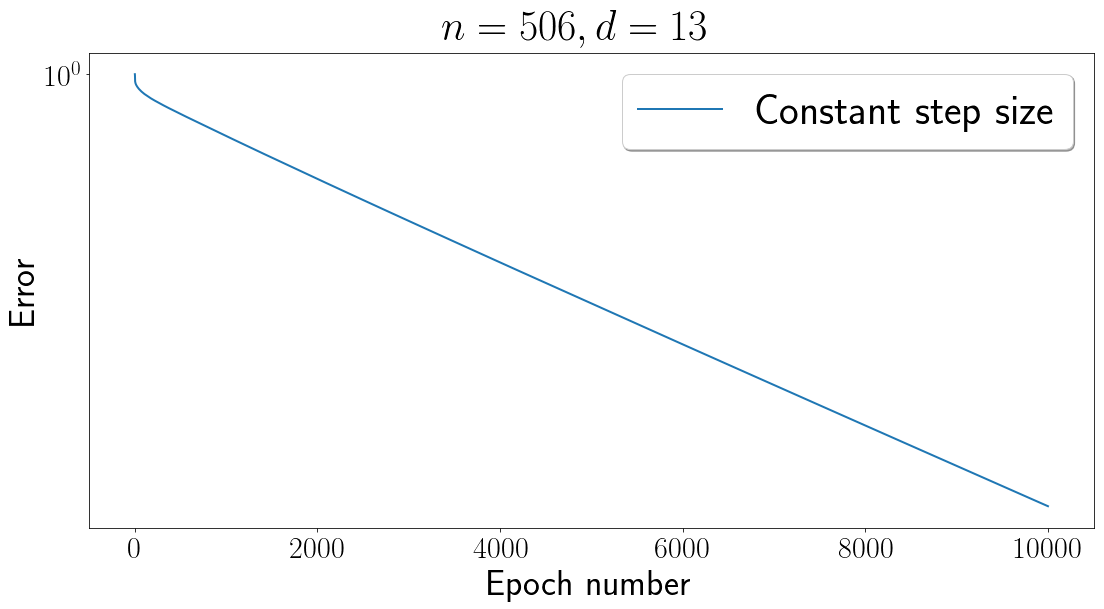

In [19]:
"""PLOTTING"""
fig = plt.figure(figsize=(18, 8))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), fontsize=42)
# n, d = 1000, 100
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=42)


plt.semilogy(x_err_const / la.norm(x_0 - x_star)**2, label='Constant step size')#, marker='o', markersize=35, markevery=10, linewidth=5)
# plt.semilogy(x_err_adapt / la.norm(x_0 - x_star)**2, label='Decreasing step size')#, marker='D', markersize=35, markevery=10, linewidth=5)
# plt.axhline(2 * step_size * sigma_2 / mu, color='g', linestyle='--', label="Neighborhood region size")
# plt.axvline(k_switch, color='r', linewidth=5, label="Regime switch")

plt.xlabel("Epoch number")
plt.ylabel("Error") #  r"$\|x_k - x^*\|^2$

# plt.xlim((0, 100))
# plt.grid()
plt.minorticks_off()
plt.legend(loc='best', shadow=True, fontsize=42)

st.set_y(1.03)
fig.subplots_adjust(top=0.95)
# plt.tight_layout()
# plt.savefig('Sum-of-Non-Convex_Objectives_bodyfat.pdf'.format(n, d, scale), bbox_inches='tight')
plt.show()

In [14]:
def const_vs_decr_ss_comparison(n, d, scale=10, epsilon=1e-3, max_epoch=1000, seed=0):
    np.random.seed(seed)
        
    a = np.random.normal(scale=scale, size=(n, d)) #np.random.binomial(n=1, p=0.5, size=(n, d))
    # Matrix normalization for ||a||_2 = 1
    # a = np.nan_to_num(a / (la.norm(a, axis=1, ord=2)).reshape(a.shape[0], -1))

    A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

    b = np.random.normal(scale=scale, size=d) #np.random.binomial(1, 0.5, size=d)#.reshape((d, -1))
       #np.random.rand(d)

    # Analytical solution
    x_star = solution(A, b)

    # Problem constants
    mu = min(la.eigvals(A))
    print("Mu =", mu)
    
    # Decomposition
    delta = np.random.normal(scale=scale)
    D = [np.zeros((d, d)) for i in range(n)]

    for j in range(d):
        indxs = np.random.choice(n, size=int(n/2), replace=False)
        for i in range(n):
            if i in indxs:
                D[i][j, j] = delta #unit_impulse(shape=(d, d), idx=indx)
            else: 
                D[i][j, j] = - delta

    M = calculate_M(a, D)
    h = calculate_h(a, b, D, x_star)
    
    sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)
    print("Sigma_2 = {} \nL_curly = {} \n".format(sigma_2, L_curly))

    step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
#     step_size = 1 / (2 * L_curly)
    print("Step size:", step_size)

    x_0 = np.random.normal(scale=scale, size=len(x_star))
    print("Expected minimum number of steps for epsilon-accuracy:", 
          max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))


    # Constant step-size
    x_const, f_vals_const, x_err_const = sgd(a, b, D, x_0, x_star, step_size, batch_size=1, epsilon=epsilon, max_epoch=max_epoch)

    # Decreasing step-size
    x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(a, b, D, x_0, x_star, L_curly, mu, batch_size=1, epsilon=epsilon, max_epoch=max_epoch)
    
    return [x_const, x_adapt], \
           [f_vals_const- f(A, b, x_star), f_vals_adapt - f(A, b, x_star)], \
           [x_err_const / la.norm(x_star - x_0)**2, x_err_adapt/ la.norm(x_star - x_0)**2]

In [23]:
n, d = 100, 10
[x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt] = const_vs_decr_ss_comparison(n, d, scale=10, epsilon=1e-4, max_epoch=1000)

  1%|▏         | 1260/100000 [00:00<00:07, 12591.07it/s]

Mu = 59.820987700067974
Sigma_2 = 4949.844075837353 
L_curly = 2415.6557475879013 

Step size: 3.0213571772939236e-07
Expected minimum number of steps for epsilon-accuracy: 952488.7038590955


  3%|▎         | 3457/100000 [00:00<00:05, 16263.60it/s]

Number of epochs: 1000
Error: 15.950570468094245



  5%|▍         | 4614/100000 [00:00<00:06, 14497.49it/s]

Number of epochs: 48
Error: 9.380642216459164e-05



NameError: name 'st' is not defined

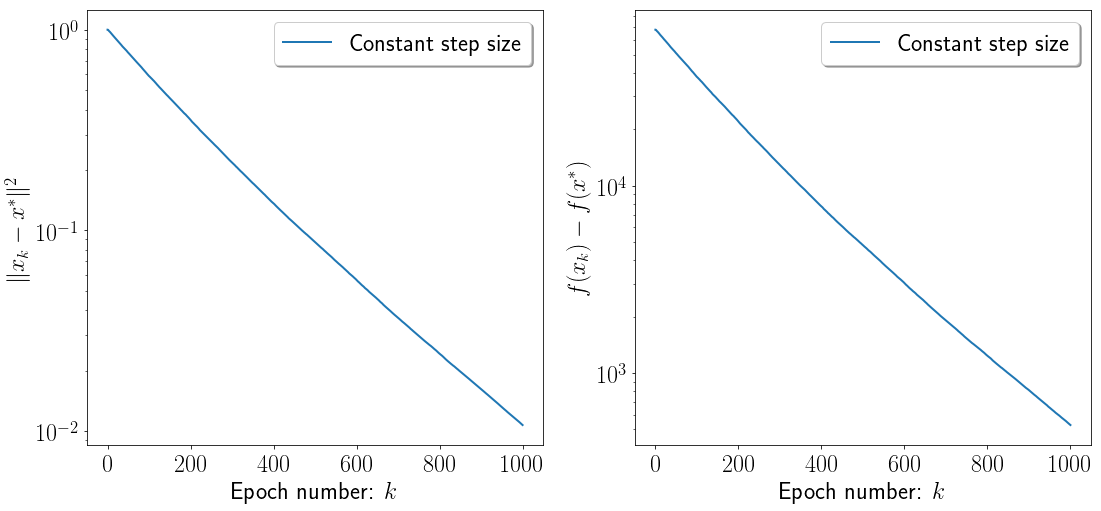

In [24]:
"""PLOTTING"""
# k_switch = int(4 * np.ceil(L_curly / mu) / n)
# print("Regime switch:", k_switch)

fig = plt.figure(figsize=(18, 8))
# st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

# plt.semilogy(x_err_const / la.norm(x_star - x_0)**2, label='Constant step size')
# plt.semilogy(x_err_adapt / la.norm(x_star - x_0)**2, label='Decreasing step size')
plt.semilogy(x_err_const, label='Constant step size')# / la.norm(x_star - x_0)**2, label='Constant step size')
# plt.semilogy(x_err_adapt, label='Decreasing step size')# / la.norm(x_star - x_0)**2, label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

# plt.semilogy(f_vals_const - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Constant step size')
# plt.semilogy(f_vals_adapt - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Decreasing step size')
plt.semilogy(f_vals_const, label='Constant step size')# - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Constant step size')
# plt.semilogy(f_vals_adapt, label='Decreasing step size')# - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

# st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
# plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

In [111]:
# scalings = {}

# for scale in range(1, 15):#[1, 5, 10, 15, 20]:
#     print("\nSCALE = {}".format(scale))
#     [x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt] = const_vs_decr_ss_comparison(n=1000, d=10, scale=scale, epsilon=1e-3, max_epoch=1000)
#     scalings[scale] = [[x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt]]


SCALE = 1
Mu = 0.7934092866359179
Sigma_2 = 101.40263828577272 
L_curly = 26.092847959149136 

Step size: 1.9560863998428064e-06
Expected minimum number of steps for epsilon-accuracy: 7070433.350752065


  0%|          | 1205/1000000 [00:00<01:38, 10158.48it/s]

Number of epochs: 1000
Error: 0.7327909442480387



  0%|          | 0/1000000 [00:00<?, ?it/s]

Number of epochs: 141
Error: 0.0009027072930497287


SCALE = 2
Mu = 3.1736371465436717
Sigma_2 = 400.99596660130254 
L_curly = 104.91936780202347 

Step size: 1.978596676072753e-06
Expected minimum number of steps for epsilon-accuracy: 1928481.5330487485


  0%|          | 1458/1000000 [00:00<01:08, 14578.69it/s]


Number of epochs: 768
Error: 0.0009930387146603742



  2%|▏         | 16554/1000000 [00:01<01:13, 13349.68it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Number of epochs: 18
Error: 0.0009617432195041575


SCALE = 3
Mu = 7.140683579723235
Sigma_2 = 900.4247037155118 
L_curly = 236.48268162190152 

Step size: 1.982587647322959e-06
Expected minimum number of steps for epsilon-accuracy: 912974.4019642596



 35%|███▍      | 346825/1000000 [00:22<00:32, 19856.59it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 1221/1000000 [00:00<01:21, 12203.29it/s]

Number of epochs: 348
Error: 0.0009857673093027943





  0%|          | 2137/1000000 [00:00<01:29, 11094.72it/s]

  0%|          | 3590/1000000 [00:00<01:23, 11941.60it/s]

  1%|          | 5418/1000000 [00:00<01:14, 13327.42it/s]

  1%|          | 7155/1000000 [00:00<01:09, 14327.18it/s]

  1%|          | 8871/1000000 [00:00<01:05, 15073.51it/s]

  1%|          | 10306/1000000 [00:00<01:06, 14847.17it/s]

  1%|          | 12179/1000000 [00:00<01:02, 15831.65it/s]



  0%|          | 0/1000000 [00:00<?, ?it/s]

Number of epochs: 14
Error: 0.000991866655840035


SCALE = 4
Mu = 12.694548586174687
Sigma_2 = 1599.6888496283962 
L_curly = 420.78277302722154 

Step size: 1.9839090253588377e-06
Expected minimum number of steps for epsilon-accuracy: 536279.5102688312




  0%|          | 1566/1000000 [00:00<01:03, 15652.81it/s]

  0%|          | 2814/1000000 [00:00<01:08, 14539.00it/s]

  0%|          | 4689/1000000 [00:00<01:03, 15589.08it/s]

  1%|          | 6872/1000000 [00:00<00:58, 17050.48it/s]

  1%|          | 9116/1000000 [00:00<00:53, 18373.86it/s]

  1%|          | 11286/1000000 [00:00<00:51, 19259.34it/s]

  1%|▏         | 13436/1000000 [00:00<00:49, 19879.80it/s]

  2%|▏         | 15370/1000000 [00:00<00:49, 19714.56it/s]

  2%|▏         | 17649/1000000 [00:00<00:47, 20544.47it/s]

  2%|▏         | 19674/1000000 [00:01<00:50, 19316.07it/s]

  2%|▏         | 21889/1000000 [00:01<00:48, 20086.79it/s]

  2%|▏         | 23902/1000000 [00:01<00:50, 19379.55it/s]

  3%|▎         | 26064/1000000 [00:01<00:48, 20001.19it/s]

  3%|▎         | 28075/1000000 [00:01<00:48, 19935.28it/s]

  3%|▎         | 30255/1000000 [00:01<00:47, 20460.27it/s]

  3%|▎         | 32310/1000000 [00:01<00:47, 20356.33it/s]

  3%|▎         | 34352/1000000 [00:01<00:47

Number of epochs: 209
Error: 0.00095933780606053



  0%|          | 2696/1000000 [00:00<01:13, 13545.66it/s]


  0%|          | 3982/1000000 [00:00<01:14, 13331.49it/s]


  1%|          | 5909/1000000 [00:00<01:07, 14689.17it/s]


  1%|          | 7930/1000000 [00:00<01:02, 15999.33it/s]


  1%|          | 9948/1000000 [00:00<00:58, 17059.33it/s]


  1%|          | 11558/1000000 [00:00<01:01, 16098.48it/s]





  0%|          | 0/1000000 [00:00<?, ?it/s]

Number of epochs: 13
Error: 0.0007814678260944978


SCALE = 5
Mu = 19.835232165897917
Sigma_2 = 2498.7884043399645 
L_curly = 657.8196387802102 

Step size: 1.9844849739425256e-06
Expected minimum number of steps for epsilon-accuracy: 354542.79766926426





  0%|          | 1401/1000000 [00:00<01:11, 14005.64it/s]


  0%|          | 2903/1000000 [00:00<01:09, 14294.66it/s]


  0%|          | 4447/1000000 [00:00<01:08, 14618.15it/s]


  1%|          | 5681/1000000 [00:00<01:11, 13849.62it/s]


  1%|          | 7244/1000000 [00:00<01:09, 14337.34it/s]


  1%|          | 8803/1000000 [00:00<01:07, 14689.87it/s]


  1%|          | 10397/1000000 [00:00<01:05, 15042.24it/s]


  1%|          | 11932/1000000 [00:00<01:05, 15131.80it/s]


  1%|▏         | 13446/1000000 [00:00<01:05, 15132.43it/s]


  1%|▏         | 14969/1000000 [00:01<01:04, 15160.67it/s]


  2%|▏         | 16473/1000000 [00:01<01:05, 15123.81it/s]


  2%|▏         | 17960/1000000 [00:01<01:05, 14915.23it/s]


  2%|▏         | 19507/1000000 [00:01<01:05, 15075.80it/s]


  2%|▏         | 21004/1000000 [00:01<01:08, 14338.68it/s]


  2%|▏         | 22549/1000000 [00:01<01:06, 14654.66it/s]


  2%|▏         | 24016/1000000 [00:01<01:10, 13749.89it/s]


  3%|▎         | 25404/1000

Number of epochs: 138
Error: 0.0009770833046736762



  0%|          | 2795/1000000 [00:00<01:11, 13882.55it/s]



  0%|          | 4005/1000000 [00:00<01:14, 13292.26it/s]



  1%|          | 5409/1000000 [00:00<01:13, 13507.77it/s]



  1%|          | 6856/1000000 [00:00<01:12, 13781.79it/s]







  0%|          | 0/1000000 [00:00<?, ?it/s]

Number of epochs: 9
Error: 0.0009996299814820434


SCALE = 6
Mu = 28.56273431889294
Sigma_2 = 3597.7233678502075 
L_curly = 947.5932778072096 

Step size: 1.9847783861131316e-06
Expected minimum number of steps for epsilon-accuracy: 252641.6785227371






  0%|          | 1469/1000000 [00:00<01:08, 14684.27it/s]



  0%|          | 2989/1000000 [00:00<01:07, 14834.05it/s]



  0%|          | 4520/1000000 [00:00<01:06, 14972.30it/s]



  1%|          | 6085/1000000 [00:00<01:05, 15164.65it/s]



  1%|          | 7622/1000000 [00:00<01:05, 15225.04it/s]



  1%|          | 8899/1000000 [00:00<01:12, 13673.43it/s]



  1%|          | 10534/1000000 [00:00<01:08, 14378.99it/s]



  1%|          | 12058/1000000 [00:00<01:07, 14626.86it/s]



  1%|▏         | 13525/1000000 [00:00<01:07, 14639.52it/s]



  2%|▏         | 15164/1000000 [00:01<01:05, 15119.80it/s]



  2%|▏         | 16941/1000000 [00:01<01:02, 15827.75it/s]



  2%|▏         | 18515/1000000 [00:01<01:02, 15799.90it/s]



  2%|▏         | 20089/1000000 [00:01<01:03, 15467.55it/s]



  2%|▏         | 21747/1000000 [00:01<01:01, 15784.70it/s]



  2%|▏         | 23325/1000000 [00:01<01:02, 15505.35it/s]



  2%|▏         | 24877/1000000 [00:01<01:06, 14665.39it/s]



  3%|▎    

Number of epochs: 98
Error: 0.0009291498731888824







  0%|          | 2522/1000000 [00:00<01:21, 12175.76it/s]



  0%|          | 3758/1000000 [00:00<01:21, 12230.45it/s]



  1%|          | 5636/1000000 [00:00<01:12, 13658.37it/s]





 21%|██        | 206508/1000000 [00:30<00:52, 14974.95it/s]



  0%|          | 0/1000000 [00:00<?, ?it/s]

Number of epochs: 8
Error: 0.0007911745446475127


SCALE = 7
Mu = 38.87705504515995
Sigma_2 = 4896.493740159123 
L_curly = 1290.1036896494504 

Step size: 1.9849435692271787e-06
Expected minimum number of steps for epsilon-accuracy: 189610.62120009313






  0%|          | 1762/1000000 [00:00<00:56, 17616.82it/s]



  0%|          | 3316/1000000 [00:00<00:58, 16934.43it/s]



  0%|          | 4893/1000000 [00:00<01:00, 16565.97it/s]



  1%|          | 6380/1000000 [00:00<01:02, 16017.19it/s]



  1%|          | 7664/1000000 [00:00<01:06, 14908.88it/s]



  1%|          | 8880/1000000 [00:00<01:12, 13636.36it/s]



  1%|          | 10372/1000000 [00:00<01:10, 13994.50it/s]



  1%|          | 11953/1000000 [00:00<01:08, 14493.01it/s]



  1%|▏         | 13558/1000000 [00:00<01:06, 14925.81it/s]



  2%|▏         | 15000/1000000 [00:01<01:08, 14404.80it/s]



  2%|▏         | 16409/1000000 [00:01<01:12, 13553.68it/s]



  2%|▏         | 17893/1000000 [00:01<01:10, 13913.49it/s]



  2%|▏         | 19426/1000000 [00:01<01:08, 14308.42it/s]



  2%|▏         | 20959/1000000 [00:01<01:07, 14599.81it/s]



  2%|▏         | 22420/1000000 [00:01<01:08, 14169.24it/s]



  2%|▏         | 23841/1000000 [00:01<01:10, 13872.67it/s]



  3%|▎    

Number of epochs: 78
Error: 0.0008838623161551687







  0%|          | 2927/1000000 [00:00<01:13, 13519.22it/s]







  0%|          | 0/1000000 [00:00<?, ?it/s]

Number of epochs: 5
Error: 0.0009555394873959587


SCALE = 8
Mu = 50.77819434469875
Sigma_2 = 6395.0995212667185 
L_curly = 1685.350874077996 

Step size: 1.985043163747387e-06
Expected minimum number of steps for epsilon-accuracy: 147821.37123155312






  0%|          | 1472/1000000 [00:00<01:07, 14718.54it/s]



  0%|          | 3168/1000000 [00:00<01:05, 15325.09it/s]



  0%|          | 4447/1000000 [00:00<01:08, 14464.12it/s]



  1%|          | 6507/1000000 [00:00<01:02, 15883.02it/s]



  1%|          | 8644/1000000 [00:00<00:57, 17208.53it/s]



  1%|          | 10929/1000000 [00:00<00:53, 18584.08it/s]



  1%|▏         | 12694/1000000 [00:00<00:56, 17594.99it/s]



  1%|▏         | 14399/1000000 [00:00<00:58, 16966.73it/s]



  2%|▏         | 16063/1000000 [00:00<00:59, 16548.19it/s]



  2%|▏         | 17697/1000000 [00:01<01:01, 15938.29it/s]



  2%|▏         | 19281/1000000 [00:01<01:01, 15907.24it/s]



  2%|▏         | 20892/1000000 [00:01<01:01, 15965.44it/s]



  2%|▏         | 22484/1000000 [00:01<01:03, 15312.97it/s]



  2%|▏         | 24018/1000000 [00:01<01:03, 15250.75it/s]



  3%|▎         | 25617/1000000 [00:01<01:03, 15463.00it/s]



  3%|▎         | 27166/1000000 [00:01<01:03, 15397.98it/s]



  3%|▎   

Number of epochs: 62
Error: 0.0008969198111161843







  0%|          | 3280/1000000 [00:00<01:00, 16438.59it/s]







  0%|          | 0/1000000 [00:00<?, ?it/s]

Number of epochs: 5
Error: 0.0007457382772021169


SCALE = 9
Mu = 64.2661522175093
Sigma_2 = 8093.540711173014 
L_curly = 2133.334830965841 

Step size: 1.9851062257829514e-06
Expected minimum number of steps for epsilon-accuracy: 118644.61136730171






  0%|          | 1446/1000000 [00:00<01:09, 14454.64it/s]



  0%|          | 3046/1000000 [00:00<01:06, 14885.88it/s]



  0%|          | 4383/1000000 [00:00<01:09, 14396.16it/s]



  1%|          | 5998/1000000 [00:00<01:06, 14880.60it/s]



  1%|          | 7561/1000000 [00:00<01:05, 15096.89it/s]



  1%|          | 9117/1000000 [00:00<01:05, 15231.24it/s]


 14%|█▎        | 135521/1000000 [00:26<00:50, 17253.47it/s]



  1%|          | 10638/1000000 [00:00<01:04, 15223.08it/s]



  1%|          | 12045/1000000 [00:00<01:08, 14470.96it/s]



  1%|▏         | 13568/1000000 [00:00<01:07, 14689.20it/s]



  2%|▏         | 15582/1000000 [00:01<01:01, 15985.83it/s]



  2%|▏         | 17179/1000000 [00:01<01:02, 15654.91it/s]



  2%|▏         | 18747/1000000 [00:01<01:02, 15660.04it/s]



  2%|▏         | 20314/1000000 [00:01<01:05, 15019.01it/s]



  2%|▏         | 22034/1000000 [00:01<01:02, 15612.60it/s]



  2%|▏         | 24250/1000000 [00:01<00:56, 17129.59it/s]



  3%|▎    

Number of epochs: 48
Error: 0.0009319926157555681








  0%|          | 2866/1000000 [00:00<01:09, 14354.13it/s]









  0%|          | 0/1000000 [00:00<?, ?it/s]






Number of epochs: 4
Error: 0.0008900057834968299


SCALE = 10
Mu = 79.34092866359167
Sigma_2 = 9991.817309877966 
L_curly = 2634.055560236854 

Step size: 1.985147601356632e-06
Expected minimum number of steps for epsilon-accuracy: 97440.77384591733


  0%|          | 1575/1000000 [00:00<01:03, 15742.47it/s]




  0%|          | 3064/1000000 [00:00<01:04, 15475.54it/s]




  0%|          | 4638/1000000 [00:00<01:03, 15553.21it/s]




  1%|          | 5955/1000000 [00:00<01:07, 14750.31it/s]




  1%|          | 7469/1000000 [00:00<01:06, 14864.22it/s]




  1%|          | 8835/1000000 [00:00<01:08, 14479.44it/s]




  1%|          | 10315/1000000 [00:00<01:07, 14571.72it/s]




  1%|          | 11922/1000000 [00:00<01:05, 14989.69it/s]




  1%|▏         | 13459/1000000 [00:00<01:05, 15100.85it/s]




  2%|▏         | 15377/1000000 [00:01<01:01, 16129.72it/s]




  2%|▏         | 16969/1000000 [00:01<01:01, 15962.55it/s]




  2%|▏         | 18551/1000000 [00:01<01:01, 15913.04it/s]




  2%|▏         | 20132/1000000 [00:01<01:01, 15869.21it/s]




  2%|▏         | 21712/1000000 [00:01<01:01, 15797.85it/s]




  2%|▏         | 23287/1000000 [00:01<01:02, 15674.42it/s]




  2%|▏         | 24852/1000000 [00:01<01:02, 15580.33it/s]




Number of epochs: 41
Error: 0.0007804634795466684













  0%|          | 0/1000000 [00:00<?, ?it/s]

Number of epochs: 4
Error: 0.0007691156371608275


SCALE = 11
Mu = 96.00252368294598
Sigma_2 = 12089.929317381595 
L_curly = 3187.513061842634 

Step size: 1.9851754539400806e-06
Expected minimum number of steps for epsilon-accuracy: 81530.34102225267







  0%|          | 1202/1000000 [00:00<01:23, 12019.67it/s]




  0%|          | 2622/1000000 [00:00<01:19, 12600.03it/s]




  0%|          | 4090/1000000 [00:00<01:15, 13159.17it/s]




  1%|          | 5364/1000000 [00:00<01:16, 13029.16it/s]




  1%|          | 6498/1000000 [00:00<01:19, 12469.61it/s]




  1%|          | 8288/1000000 [00:00<01:12, 13717.37it/s]




  1%|          | 9602/1000000 [00:00<01:13, 13537.81it/s]




  1%|          | 10890/1000000 [00:00<01:16, 12907.10it/s]




  1%|          | 12221/1000000 [00:00<01:15, 13024.42it/s]




  1%|▏         | 14073/1000000 [00:01<01:08, 14294.79it/s]




  2%|▏         | 15521/1000000 [00:01<01:10, 14050.43it/s]




  2%|▏         | 17009/1000000 [00:01<01:08, 14287.37it/s]




  2%|▏         | 18548/1000000 [00:01<01:07, 14600.61it/s]




  2%|▏         | 20226/1000000 [00:01<01:04, 15192.38it/s]




  2%|▏         | 21758/1000000 [00:01<01:06, 14701.18it/s]




  2%|▏         | 23341/1000000 [00:01<01:05, 15020.06it/s

Number of epochs: 34
Error: 0.0006176380071468726








  0%|          | 2796/1000000 [00:00<01:11, 13888.23it/s]









  0%|          | 0/1000000 [00:00<?, ?it/s]




  0%|          | 1604/1000000 [00:00<01:02, 16032.14it/s]

Number of epochs: 4
Error: 0.000684887483316156


SCALE = 12
Mu = 114.25093727557176
Sigma_2 = 14387.876733683914 
L_curly = 3793.7073357509325 

Step size: 1.9851945389568024e-06
Expected minimum number of steps for epsilon-accuracy: 69275.8328368552







  0%|          | 2976/1000000 [00:00<01:05, 15257.81it/s]




  0%|          | 4642/1000000 [00:00<01:03, 15653.04it/s]




  1%|          | 6104/1000000 [00:00<01:04, 15325.71it/s]




  1%|          | 7521/1000000 [00:00<01:06, 14955.04it/s]




  1%|          | 9059/1000000 [00:00<01:05, 15079.91it/s]




  1%|          | 10384/1000000 [00:00<01:10, 14136.62it/s]




  1%|          | 11861/1000000 [00:00<01:09, 14320.69it/s]




  1%|▏         | 13213/1000000 [00:00<01:14, 13201.31it/s]




  1%|▏         | 14550/1000000 [00:01<01:14, 13251.19it/s]




  2%|▏         | 15848/1000000 [00:01<01:16, 12834.01it/s]




  2%|▏         | 17115/1000000 [00:01<01:19, 12328.00it/s]




  2%|▏         | 18462/1000000 [00:01<01:17, 12649.24it/s]




  2%|▏         | 20250/1000000 [00:01<01:10, 13864.97it/s]




  2%|▏         | 21743/1000000 [00:01<01:09, 14165.88it/s]




  2%|▏         | 23185/1000000 [00:01<01:11, 13746.65it/s]




  2%|▏         | 24646/1000000 [00:01<01:09, 13994.27it

Number of epochs: 29
Error: 0.0008959902720351475

Number of epochs: 4
Error: 0.000626187944857232


SCALE = 13







  0%|          | 0/1000000 [00:00<?, ?it/s]


Mu = 134.08616944146982
Sigma_2 = 16885.65955878492 
L_curly = 4452.638381939429 

Step size: 1.985207758315106e-06
Expected minimum number of steps for epsilon-accuracy: 59629.66436138307








  0%|          | 1680/1000000 [00:00<00:59, 16797.49it/s]





  0%|          | 3370/1000000 [00:00<00:59, 16827.70it/s]





  1%|          | 5039/1000000 [00:00<00:59, 16785.76it/s]





  1%|          | 6213/1000000 [00:00<01:06, 14861.69it/s]





  1%|          | 7580/1000000 [00:00<01:08, 14482.13it/s]





  1%|          | 8999/1000000 [00:00<01:08, 14390.08it/s]





  1%|          | 10841/1000000 [00:00<01:04, 15400.48it/s]





  1%|          | 12278/1000000 [00:00<01:06, 14910.48it/s]





  1%|▏         | 13701/1000000 [00:00<01:10, 13929.04it/s]





  2%|▏         | 15161/1000000 [00:01<01:09, 14123.10it/s]





  2%|▏         | 16875/1000000 [00:01<01:05, 14909.52it/s]





  2%|▏         | 18361/1000000 [00:01<01:08, 14396.02it/s]





  2%|▏         | 19801/1000000 [00:01<01:11, 13664.16it/s]





  2%|▏         | 21277/1000000 [00:01<01:10, 13975.29it/s]





  2%|▏         | 22682/1000000 [00:01<01:10, 13934.69it/s]











  0%|          | 0/1000000 [00:00<

Number of epochs: 25
Error: 0.0009280378978253289



  0%|          | 2696/1000000 [00:00<01:12, 13839.90it/s]











  0%|          | 0/1000000 [00:00<?, ?it/s]

Number of epochs: 4
Error: 0.0005859725740264239


SCALE = 14
Mu = 155.5082201806398
Sigma_2 = 19583.277792684552 
L_curly = 5164.3062003922 

Step size: 1.9852169517649748e-06
Expected minimum number of steps for epsilon-accuracy: 51895.740143584226








  0%|          | 1575/1000000 [00:00<01:03, 15744.80it/s]





  0%|          | 3140/1000000 [00:00<01:03, 15715.90it/s]





  0%|          | 4701/1000000 [00:00<01:03, 15683.49it/s]





  1%|          | 5748/1000000 [00:00<01:12, 13643.47it/s]





  1%|          | 6992/1000000 [00:00<01:14, 13256.38it/s]





  1%|          | 8413/1000000 [00:00<01:13, 13528.62it/s]





  1%|          | 9991/1000000 [00:00<01:10, 14133.23it/s]





  1%|          | 11437/1000000 [00:00<01:09, 14228.64it/s]





  1%|▏         | 12788/1000000 [00:00<01:11, 13795.90it/s]





  1%|▏         | 14368/1000000 [00:01<01:08, 14341.35it/s]





  2%|▏         | 15944/1000000 [00:01<01:06, 14738.90it/s]





  2%|▏         | 17447/1000000 [00:01<01:06, 14823.53it/s]





  2%|▏         | 19039/1000000 [00:01<01:04, 15136.16it/s]





  2%|▏         | 20547/1000000 [00:01<01:05, 15037.22it/s]











  0%|          | 0/1000000 [00:00<?, ?it/s]





  0%|          | 1377/1000000 [00:00<01:12, 13766.

Number of epochs: 22
Error: 0.0006529245551455481



  0%|          | 2800/1000000 [00:00<01:11, 13899.89it/s]







Number of epochs: 4
Error: 0.0005596077011296349







  5%|▍         | 46246/1000000 [00:20<01:02, 15361.04it/s]




  3%|▎         | 26655/1000000 [00:21<01:03, 15394.41it/s]

In [88]:
# scale = 12
# [x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt] = const_vs_decr_ss_comparison(n=100, d=10, scale=scale, epsilon=1e-3, max_epoch=1000)
# scalings[scale] = [[x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt]]

  1%|▏         | 1260/100000 [00:00<00:07, 12594.13it/s]

Mu = 86.14222228809793
Sigma_2 = 7120.126861105816 
L_curly = 3478.323453682557 

Step size: 3.0246027903890223e-06
Expected minimum number of steps for epsilon-accuracy: 58635.53274802932


  2%|▏         | 1589/100000 [00:00<00:06, 15889.18it/s]

Number of epochs: 260
Error: 0.0009967889915894301

Number of epochs: 24
Error: 0.0006776070112736824



In [17]:
# with open('PCA_problem.pickle', 'wb') as f:
#     pickle.dump(scalings, f)

# scalings = {}
with open('PCA_problem.pickle', 'rb') as f:
    scalings = pickle.load(f)

In [18]:
scalings.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [19]:
# Plot display settings

#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 36#24
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 42#36
plt.rcParams['axes.labelsize'] = 36#24

plt.rc('text', usetex=True)

1 D 50
2 s 30
4 o 30
10 ^ 15


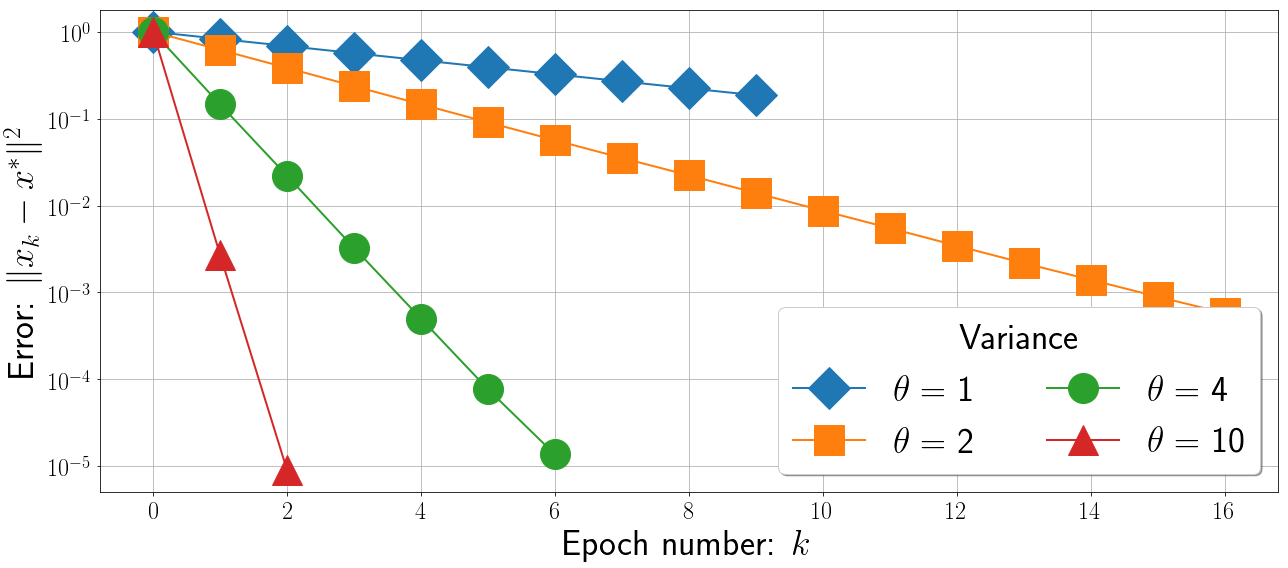

In [100]:
fig = plt.figure(figsize=(18, 8))

# for scale, marker, step in zip([1, 2, 3, 4, 5, 10], 
#                                ['D', 'X', 'o', ',', 's', 'v'],
#                                [40, 30, 30, 25, 25, 20]): #[3, 6, 9, 12, 15]:#sorted(list(scalings.keys())[1:])    
for scale, marker, step in zip([1, 2, 4, 10], 
                               ['D', 's', 'o', '^',],
                               [50, 30, 30, 15]): #[3, 6, 9, 12, 15]:#sorted(list(scalings.keys())[1:])    
    """PLOTTING"""

#     plt.subplot(1, 2, 1)
    print(scale, marker, step)
    plt.semilogy(scalings[scale][2][0][1:500:step], label=r"$\theta=$ ""{}".format(scale), marker=marker, markersize=30)
    
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"Error: $\|x_k - x^*\|^2$")
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='minor')      # both major and minor ticks are affected

plt.minorticks_off()
plt.grid()
legend = plt.legend(title="Variance", loc="lower right", ncol=2, shadow=True)#, title_size='x-large')
legend.get_title().set_fontsize('36') #legend 'Title' fontsize
# plt.setp(plt.gca().get_legend().get_texts(), fontsize='24') #legend 'list' fontsize
# st.set_y(1.05)
# fig.subplots_adjust(top=0.95)
plt.tight_layout()
# plt.savefig('Sum-of-Non-Convex_Objectives_variance.pdf', bbox_inches='tight')
plt.show()

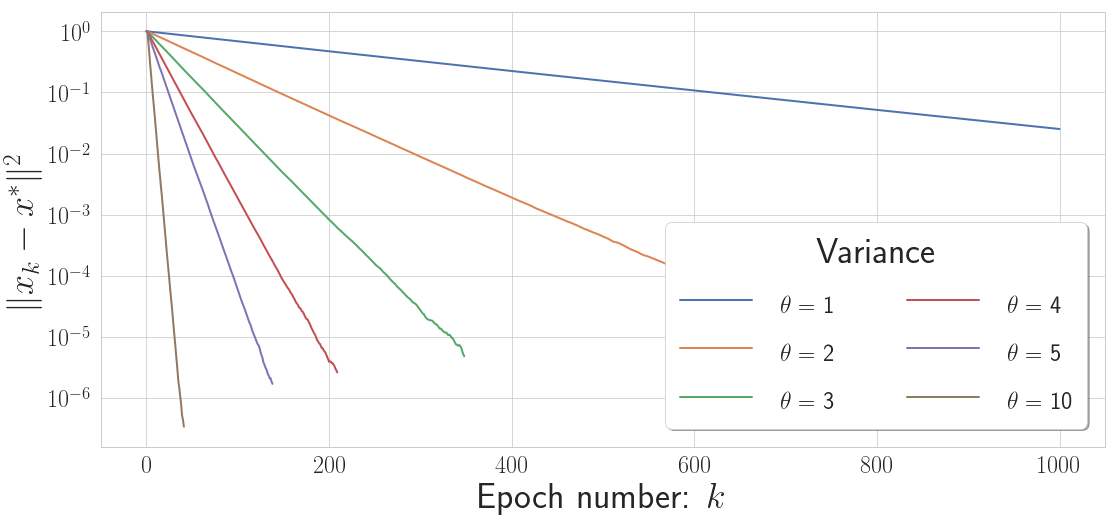

In [131]:
fig = plt.figure(figsize=(18, 8))

for scale in [1, 2, 3, 4, 5, 10]:#[3, 6, 9, 12, 15]:#sorted(list(scalings.keys())[1:])
#     print("'\n'SCALE = {}".format(scale))
#     [x_const, x_adapt], [f_vals_const, f_vals_adapt], [x_err_const, x_err_adapt] = const_vs_decr_ss_comparison(n=100, d=10, scale=scale, epsilon=1e-3, max_epoch=1000)
    
    """PLOTTING"""

#     plt.subplot(1, 2, 1)

    plt.semilogy(scalings[scale][2][0], label=r"$\theta=$ ""{}".format(scale))
    
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
legend = plt.legend(title="Variance", loc="lower right", ncol=2, shadow=True)#, title_size='x-large')
# legend = plt.legend(title=r'$\bf{Title}$') #Legend: list, location, Title (in bold)
legend.get_title().set_fontsize('36') #legend 'Title' fontsize
plt.setp(plt.gca().get_legend().get_texts(), fontsize='24') #legend 'list' fontsize

#     plt.subplot(1, 2, 2)

#     plt.semilogy(f_vals_const, label="Variance = {}".format(scale))
#     plt.xlabel("Epoch number: $k$")
#     plt.ylabel(r"$f(x_k) - f(x^*)$")
#     plt.legend(loc='best', shadow=True)#, fontsize='x-large')

# st.set_y(1.05)
# fig.subplots_adjust(top=0.95)
# plt.tight_layout()
# plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

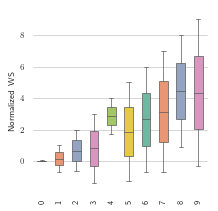

In [129]:
import seaborn as sns

df = list(zip(np.arange(10), np.random.normal(size=10)))

sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.9)                                                  
plt.figure(figsize=(3.1, 3)) # Two column paper. Each column is about 3.15 inch wide.                                                                                                                                                                                                                                 
color = sns.color_palette("Set2", 6)

# Create a box plot for my data                                                      
splot = sns.boxplot(data=df, palette=color, whis=np.inf,                              
        width=0.5, linewidth = 0.7)

# Labels and clean up on the plot                                                                                                                                                                                                                                                                                              
splot.set_ylabel('Normalized WS')                                                     
plt.xticks(rotation=90)                                                               
plt.tight_layout()                                                                    
splot.yaxis.grid(True, clip_on=False)                                                 
sns.despine(left=True, bottom=True)
plt.savefig("test_plot.pdf")

# Synthetic data generation according to Allen-Zhu (2016) paper

Random vectors $a_1, \dots, a_n \in [0, 1]^d$

In [76]:
# n = 500
# d = 20

# np.random.seed(1)

# a = np.random.binomial(n=1, p=0.5, size=(n, d)) * 10
# # Matrix normalization for ||a||_2 = 1
# # a = np.nan_to_num(a / (la.norm(a, axis=1, ord=2)).reshape(a.shape[0], -1))

# A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

# # np.random.rand(d) 
# b = np.random.binomial(1, 0.5, size=d)#.reshape((d, -1))

In [ ]:
n = 500
d = 20

np.random.seed(1)

# MY CHANGE
a = np.random.normal(scale = size=(n, d)) #np.random.binomial(n=1, p=0.5, size=(n, d))
# Matrix normalization for ||a||_2 = 1
# a = np.nan_to_num(a / (la.norm(a, axis=1, ord=2)).reshape(a.shape[0], -1))

A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

b = np.random.normal(size=d) #np.random.binomial(1, 0.5, size=d)#.reshape((d, -1))
# np.random.rand(d)

# Analytical solution
x_star = solution(A, b)

In [78]:
# Decomposition

D = [np.diag(np.random.rand(d) - unit_impulse(d, np.random.randint(d))) for i in range(n - 1)]
D += [- sum(D)]

### Constants calculation

<!---
L_i = \| \mathbf{A}(i,:) \|_2^2 + \lambda \ \ \forall i \\-->
$$
\mu = \lambda_{\text{min}}(\mathbf{A})
$$

In [79]:
mu = min(la.eigvals(A))
mu

16.867830990168628

In [11]:
def calculate_neighborhood_region(step_size, sigma_2, mu):
    return 2 * step_size * sigma_2 / mu

In our case M-smoothness:
$$
M_i = a_i a_i^T + D_i
$$

In [12]:
def calculate_M(a, D):
    n = len(D)
    return [np.outer(a[i], a[i]) + D[i] for i in range(n)]

$$
h_i = \| \nabla f_i(x^*) \|^2
$$

In [13]:
def calculate_h(a, b, D, x_star):
    n = len(D)
    return [la.norm(grad_f_i(a, b, D, i, x_star))**2 for i in range(n)]

For proper & non-vacuous uniform sampling:
$$
\sigma^2 = \frac{1}{n} \sum\limits_{i=1}^n \| \nabla f_i (x^*) \|^2 \\
\mathcal{L} = \max\limits_{i=\overline{1,n}} \lambda_{\text{max}}(M_i) \\
$$

In [14]:
def calculate_sigma_and_L_curly(M, h):
    n = len(M)
    sigma_2 = np.mean(h) #sum([la.norm(grad_f_i(a, b, D, i, x_star))**2 for i in range(n)]) / n
    L_curly = max([max(abs(la.eigvals(M[i]))) for i in range(n)])

    return sigma_2, L_curly

In [83]:
M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)
sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)
print("sigma_2 = {} \nL_curly = {}".format(sigma_2, L_curly))

sigma_2 = 203.85579471275832 
L_curly = 1700.4637195909274


In [91]:
epsilon = 1e-5

# Far from solution
x_0 = np.random.normal(size=len(x_star))

# Closer to solution
# x_0 = x_star + np.random.normal(size=len(x_star))

In [92]:
step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Step size:", step_size)

print("Expected minimum number of steps:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

Step size: 2.0685984195269183e-07
Expected minimum number of steps: 4318089.144151602


In [93]:
max_epoch = 10000

In [94]:
%%time
x_opt, f_vals, x_err = sgd(A, b, D, x_0, x_star, step_size, batch_size=1,
                           epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 3465
Error: 9.883662258805172e-06

CPU times: user 1min 28s, sys: 800 ms, total: 1min 29s
Wall time: 1min 32s


In [95]:
# %%time
# x_opt_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, b, D, x_0, x_star, L_curly, mu, batch_size=1, 
#                                                       epsilon=epsilon, max_epoch=max_epoch)

In [96]:
# # Switching regime from constant to decreasing step size
# k_switch = int(4 * np.ceil(L_curly / mu)) / n
# k_switch

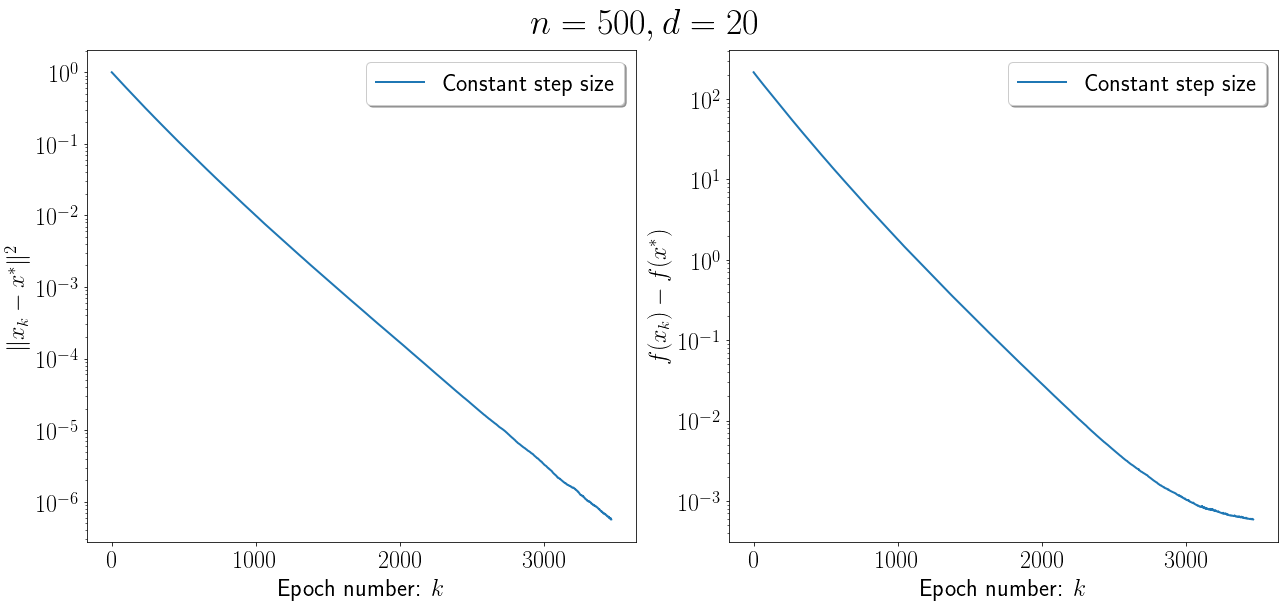

In [97]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err / la.norm(x_star - x_0)**2, label='Constant step size')
# plt.semilogy(x_err_adapt, label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Constant step size')
# plt.semilogy(f_vals_adapt - f(A, b, x_star), label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

### Another way to generate $D_i$ from Allen-Zhu paper

In [51]:
delta = 0.01

In [52]:
# Decomposition

D = [np.zeros((d, d)) for i in range(n)]

for j in range(d):
    indxs = np.random.choice(n, size=int(n/2), replace=False)
    for i in range(n):
        if i in indxs:
            D[i][j, j] = delta #unit_impulse(shape=(d, d), idx=indx)
        else: 
            D[i][j, j] = - delta

In [53]:
# mu = min(la.eigvals(A))
print("mu =", mu)

M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)
sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)

print("sigma_2 = {} \nL_curly = {}".format(sigma_2, L_curly))

mu = 18.003005549992796
sigma_2 = 12.188607451360589 
L_curly = 500.00600012799725


In [54]:
# Far from solution
x_0 = np.random.normal(size=len(x_star))

# Closer to solution
# x_0 = x_star + np.random.normal(size=len(x_star))

epsilon = 1e-5

step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Step size:", step_size)

print("Expected minimum number of steps:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

Step size: 3.6925886779590966e-06
Expected minimum number of steps: 193277.62654699475


In [55]:
max_epoch = 10000

In [56]:
%%time
x_opt, f_vals, x_err = sgd(A, b, D, x_0, x_star, step_size, batch_size=1, 
                           epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 1700
Error: 9.985977101830576e-06

CPU times: user 3.91 s, sys: 22.2 ms, total: 3.94 s
Wall time: 3.99 s


In [60]:
%%time
x_opt_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, b, D, x_0, x_star, L_curly, mu, batch_size=1, 
                                                      epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 31
Error: 7.687554106085256e-06

CPU times: user 124 ms, sys: 10.7 ms, total: 135 ms
Wall time: 137 ms


In [61]:
# Switching regime from constant to decreasing step size
k_switch = int(4 * np.ceil(L_curly / mu)) / n
k_switch

2.24

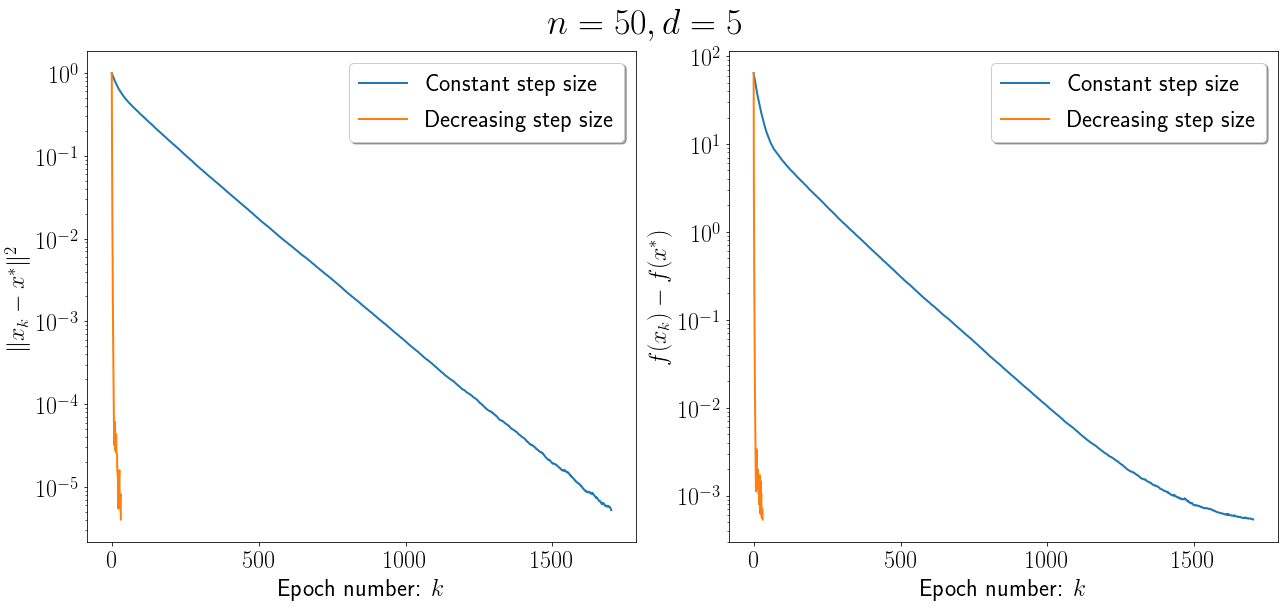

In [63]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err / la.norm(x_star - x_0)**2, label='Constant step size')
# plt.semilogy(x_err_adapt / la.norm(x_star - x_0)**2, label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Constant step size')
# plt.semilogy(f_vals_adapt - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

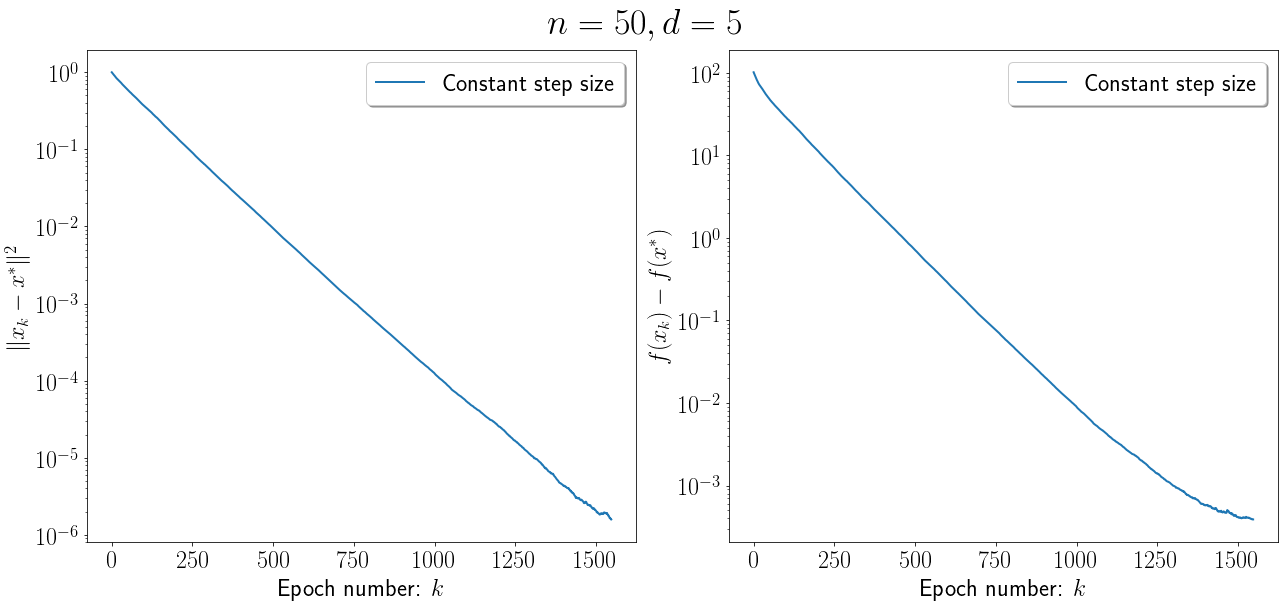

In [50]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err / la.norm(x_star - x_0)**2, label='Constant step size')
# plt.semilogy(x_err_adapt, label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Constant step size')
# plt.semilogy(f_vals_adapt - f(A, b, x_star), label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

### Third way to generate $D_i$ from Allen-Zhu (2016) paper

In [78]:
k = 5

In [79]:
# Decomposition

D = [np.eye(d) * k / (n - 1) for i in range(n)]

for j in range(d):
    ind = np.random.choice(n)
    D[ind][j, j] = - k

In [80]:
mu = min(la.eigvals(A))
print("mu =", mu)

M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)
sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)

print("sigma_2 = {} \nL_curly = {}".format(sigma_2, L_curly))

mu = 0.005510413402311755
sigma_2 = 38968.43287821895 
L_curly = 5.0


In [81]:
# Far from solution
x_0 = np.random.normal(size=len(x_star))

# Closer to solution
# x_0 = x_star + np.random.normal(size=len(x_star))

epsilon = 1e-3

step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Step size:", step_size)

print("Expected minimum number of steps:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

Step size: 0.1
Expected minimum number of steps: 96575126878236.56


In [82]:
max_epoch = 10000

In [83]:
%%time
x_opt, f_vals, x_err = sgd(A, b, D, x_0, x_star, step_size, batch_size=1, 
                           epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 10000
Error: 83422.29485135339

CPU times: user 28.5 s, sys: 187 ms, total: 28.7 s
Wall time: 30 s


In [84]:
%%time
x_opt_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, b, D, x_0, x_star, L_curly, mu, batch_size=1, 
                                                      epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 10000
Error: 905.2526547570698

CPU times: user 28.6 s, sys: 216 ms, total: 28.8 s
Wall time: 29.5 s


In [85]:
# Switching regime from constant to decreasing step size
k_switch = int(4 * np.ceil(L_curly / mu)) / n
k_switch

72.64

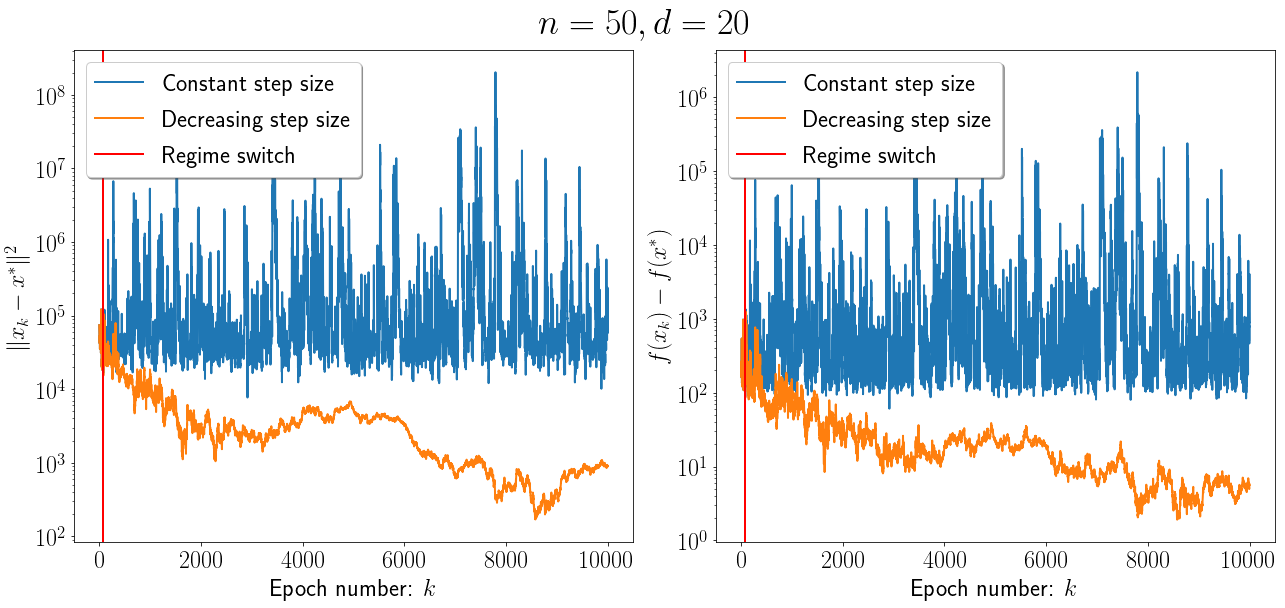

In [86]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err, label='Constant step size')
plt.semilogy(x_err_adapt, label='Decreasing step size')
plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals - f(A, b, x_star), label='Constant step size')
plt.semilogy(f_vals_adapt - f(A, b, x_star), label='Decreasing step size')
plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
# plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.savefig('3_Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

## Another type of data generation

Random vectors $a_1, \dots, a_n$ from standart multivariate normal

In [126]:
n = 10
d = 4

np.random.seed(0)

a = np.random.normal(size=(n, d))
# Matrix normalization for ||a||_2 = 1
# a = np.nan_to_num(a / (la.norm(a, axis=1, ord=2)).reshape(a.shape[0], -1))

A = sum([np.outer(a[i], a[i]) for i in range(n)]) / n

b = np.random.normal(size=d)#.reshape((d, -1))

In [127]:
# Analytical solution
x_star = solution(A, b)

In [128]:
# k = 5

In [129]:
# # Decomposition

# D = [np.eye(d) * k / (n - 1) for i in range(n)]

# for j in range(d):
#     ind = np.random.choice(n)
#     D[ind][j, j] = - k

In [130]:
# Decomposition

D = [np.diag(np.random.rand(d) - unit_impulse(d, np.random.randint(d))) for i in range(n - 1)]
D += [- sum(D)]

In [131]:
M = [np.outer(a[i], a[i]) + D[i] for i in range(n)]

mu = min(la.eigvals(A))
print("mu =", mu)

sigma_2 = sum([la.norm(grad_f_i(a, b, D, i, x_star))**2 for i in range(n)]) / n
L_curly = abs(max([max(la.eigvals(M[i])) for i in range(len(M))])) # maybe cast abs() for complex results
print("sigma_2, L_curly =", sigma_2, L_curly)

mu = 0.27231374052156554
sigma_2, L_curly = 186.69621851902124 9.359373138730774


In [132]:
# Far from solution
x_0 = np.random.normal(size=len(x_star))

# Closer to solution
# x_0 = x_star + np.random.normal(size=len(x_star))

epsilon = 1e-4

step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Step size:", step_size)

print("Expected minimum number of steps:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

Step size: 0.0534223812416357
Expected minimum number of steps: 1411738332.0786586


In [155]:
max_epoch = 500000

In [156]:
%%time
x_opt, f_vals, x_err = sgd(A, b, D, x_0, x_star, step_size, batch_size=1, 
                           epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 500000
Error: 5.246696578905769

CPU times: user 3min 39s, sys: 1.51 s, total: 3min 40s
Wall time: 3min 46s


In [157]:
%%time
x_opt_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, b, D, x_0, x_star, L_curly, mu, batch_size=1, 
                                                      epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 230580
Error: 9.766090386247642e-05

CPU times: user 1min 54s, sys: 808 ms, total: 1min 55s
Wall time: 1min 58s


In [158]:
# Switching regime from constant to decreasing step size
k_switch = int(4 * np.ceil(L_curly / mu)) / n
k_switch

14.0

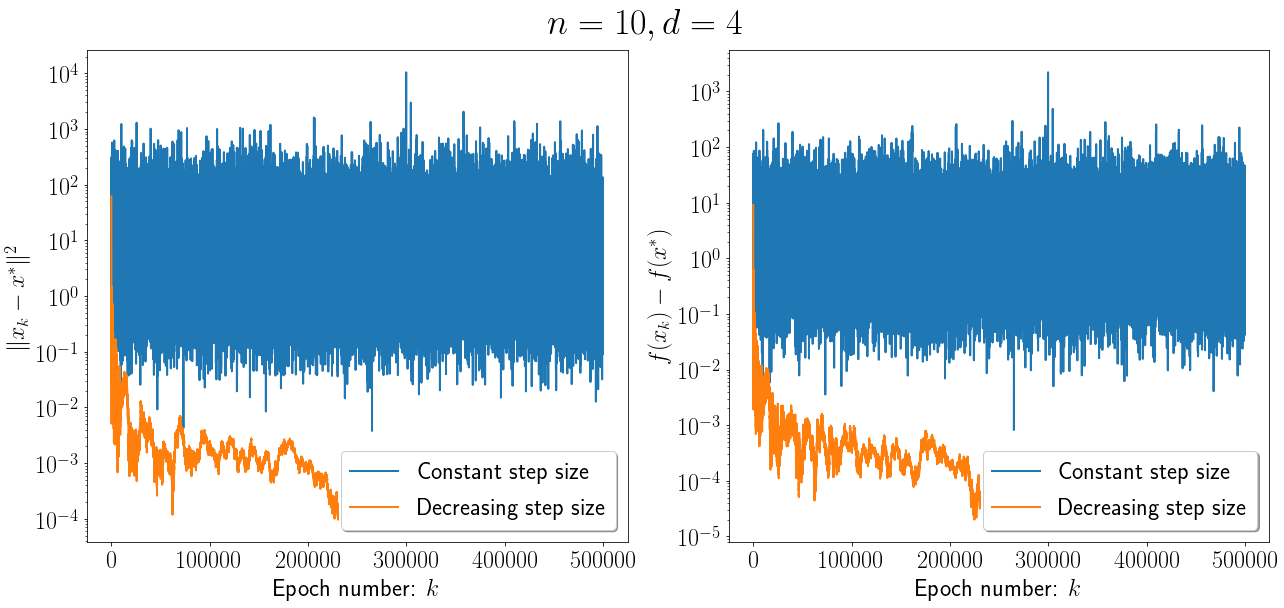

In [159]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err, label='Constant step size')
plt.semilogy(x_err_adapt, label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals - f(A, b, x_star), label='Constant step size')
plt.semilogy(f_vals_adapt - f(A, b, x_star), label='Decreasing step size')
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
# plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

### 1 type of $D_i$ generation

In [186]:
delta = 0.01

In [187]:
# Decomposition

D = [np.zeros((d, d)) for i in range(n)]

for j in range(d):
    indxs = np.random.choice(n, size=int(n/2), replace=False)
    for i in range(n):
        if i in indxs:
            D[i][j, j] = delta #unit_impulse(shape=(d, d), idx=indx)
        else: 
            D[i][j, j] = - delta

In [188]:
mu = min(la.eigvals(A))
print("mu =", mu)

M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)

sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)
print("sigma_2 = {} \nL_curly = {}".format(sigma_2, L_curly))

mu = 0.11428616525426238
sigma_2 = 51675699.091582745 
L_curly = 10000403361.240004


In [155]:
# Far from solution
x_0 = np.random.normal(size=len(x_star))

# Closer to solution
# x_0 = x_star + np.random.normal(size=len(x_star))

epsilon = 1e-3

step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Step size:", step_size)

print("Expected minimum number of steps:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

Step size: 3.955223414140725e-12
Expected minimum number of steps: 3229912033698.5234


In [162]:
max_epoch = 10000

In [163]:
%%time
x_opt, f_vals, x_err = sgd(A, b, D, x_0, x_star, step_size, batch_size=1, 
                           epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 10000
Error: 16.871033457004238

CPU times: user 5min 27s, sys: 3.1 s, total: 5min 30s
Wall time: 5min 40s


In [164]:
%%time
x_opt_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, b, D, x_0, x_star, L_curly, mu, batch_size=1, 
                                                      epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 10000
Error: 16.811196017658165

CPU times: user 6min 9s, sys: 3.46 s, total: 6min 13s
Wall time: 6min 23s


In [165]:
# Switching regime from constant to decreasing step size
k_switch = int(4 * np.ceil(L_curly / mu)) / n
k_switch

70910581.35652174

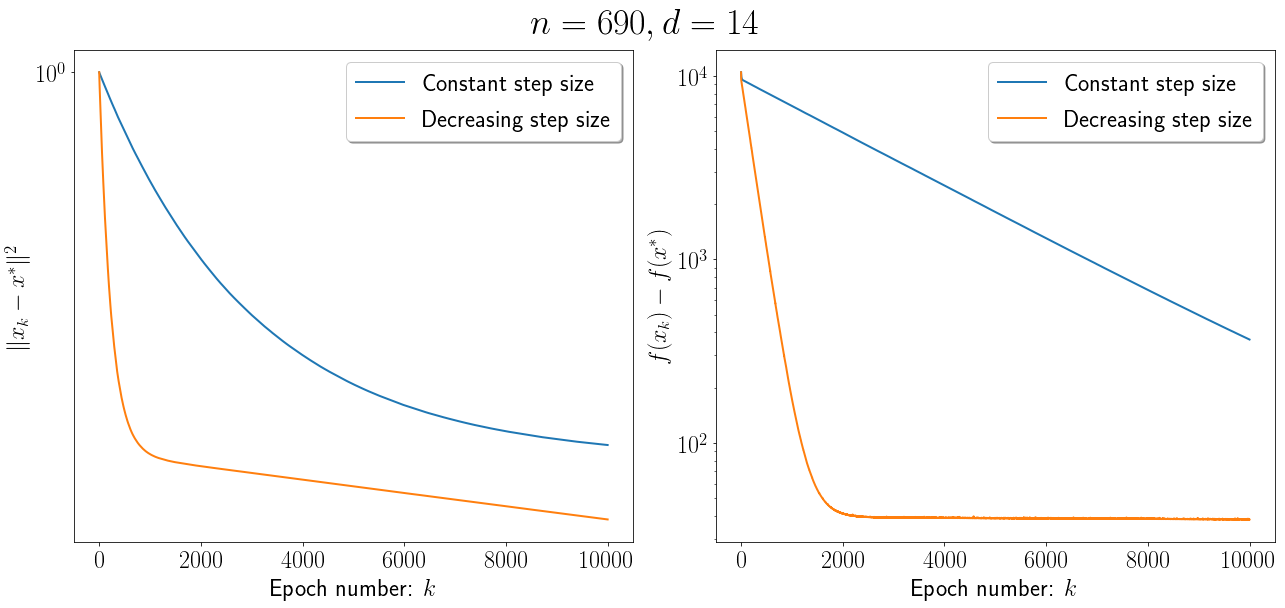

In [167]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err / la.norm(x_star - x_0)**2, label='Constant step size')
plt.semilogy(x_err_adapt / la.norm(x_star - x_0)**2, label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Constant step size')
plt.semilogy(f_vals_adapt - f(A, b, x_star) / f(A, b, x_0) - f(A, b, x_star), label='Decreasing step size')
# plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
plt.savefig('Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()

### 2 type of $D_i$ generation

In [212]:
k = 1

In [213]:
# Decomposition

D = [np.eye(d) * k / (n - 1) for i in range(n)]

for j in range(d):
    ind = np.random.choice(n)
    D[ind][j, j] = - k

In [214]:
mu = min(la.eigvals(A))
print("mu =", mu)

M = calculate_M(a, D)
h = calculate_h(a, b, D, x_star)
sigma_2, L_curly = calculate_sigma_and_L_curly(M, h)

print("sigma_2 = {} \nL_curly = {}".format(sigma_2, L_curly))

mu = 0.11428616525426238
sigma_2 = 51675699.092747554 
L_curly = 10000403361.251455


In [215]:
# Far from solution
x_0 = np.random.normal(size=len(x_star))

# Closer to solution
# x_0 = x_star + np.random.normal(size=len(x_star))

epsilon = 1e-3

step_size = select_step_size(L_curly, mu, sigma_2, epsilon)
print("Step size:", step_size)

print("Expected minimum number of steps:", 
      max(2 * L_curly / mu, 4 * sigma_2 / (epsilon * mu**2)) * np.log(2 * la.norm(x_star - x_0)**2 / epsilon))

Step size: 5.529009150371704e-13
Expected minimum number of steps: 168022557553167.03


In [216]:
1 / (2 * L_curly)

4.999798327508959e-11

In [82]:
max_epoch = 1000

In [83]:
%%time
x_opt, f_vals, x_err = sgd(A, b, D, x_0, x_star, step_size, batch_size=1, 
                           epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 10000
Error: 83422.29485135339

CPU times: user 28.5 s, sys: 187 ms, total: 28.7 s
Wall time: 30 s


In [84]:
%%time
x_opt_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, b, D, x_0, x_star, L_curly, mu, batch_size=1, 
                                                      epsilon=epsilon, max_epoch=max_epoch)

Number of epochs: 10000
Error: 905.2526547570698

CPU times: user 28.6 s, sys: 216 ms, total: 28.8 s
Wall time: 29.5 s


In [85]:
# Switching regime from constant to decreasing step size
k_switch = int(4 * np.ceil(L_curly / mu)) / n
k_switch

72.64

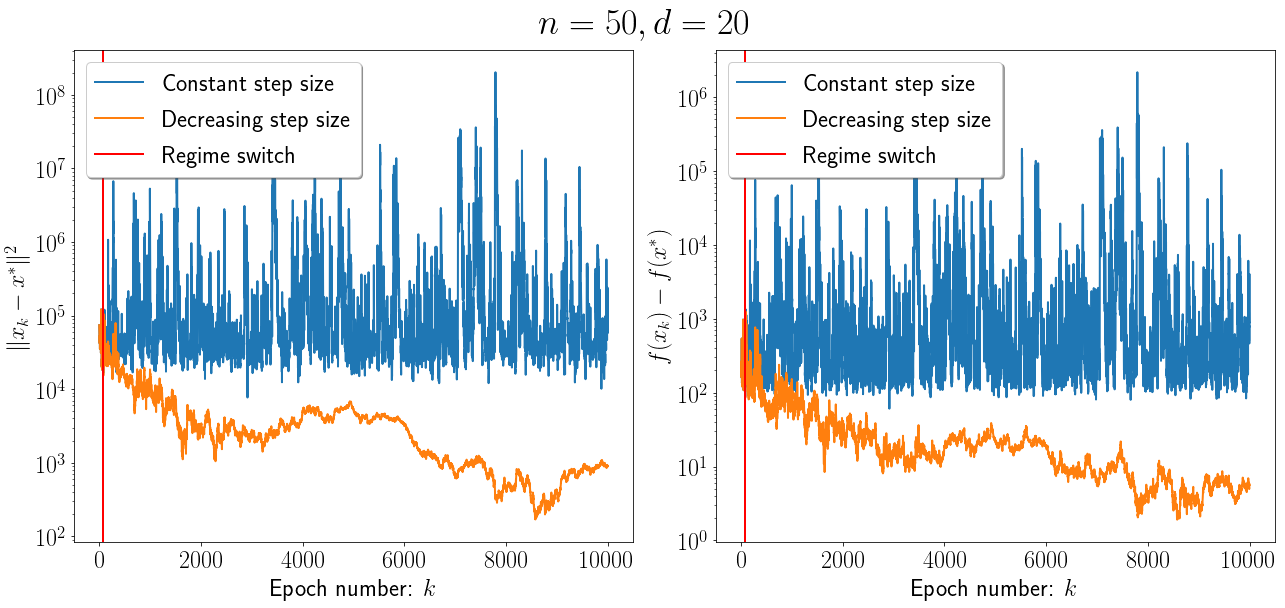

In [86]:
fig = plt.figure(figsize=(18, 8))
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=36)

plt.subplot(1, 2, 1)

plt.semilogy(x_err, label='Constant step size')
plt.semilogy(x_err_adapt, label='Decreasing step size')
plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$\|x_k - x^*\|^2$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

plt.subplot(1, 2, 2)

plt.semilogy(f_vals - f(A, b, x_star), label='Constant step size')
plt.semilogy(f_vals_adapt - f(A, b, x_star), label='Decreasing step size')
plt.axvline(k_switch, color='red', label="Regime switch")
plt.xlabel("Epoch number: $k$")
plt.ylabel(r"$f(x_k) - f(x^*)$")
plt.legend(loc='best', shadow=True)#, fontsize='x-large')

st.set_y(1.05)
fig.subplots_adjust(top=0.95)
plt.tight_layout()
# plt.savefig('synthetic_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.savefig('3_Sum-of-Non-Convex_Objectives_{}-{}.pdf'.format(n, d), bbox_inches='tight')
plt.show()